Optical properties of responsive hybrid Au@polymer nanoparticles
========

Must change title eventually

Supporting information - data analysis: import & initial plots
--------

Abstract
--------

We take a close look at the physical and optical properties of Au@PNIPAM core-shell nanoparticles.
- Small Au cores, radius $\sim$ 8.5 nm
- Wide range of shell thickness, 15 to 200 nm
- Two shell architectures: 
    - grafted/linear, thin range: [16, 65] nm
    - seeded-precipitation/cross-linked, thick range: [50, 193] nm
- Studied with UV-vis, DLS, SLS, TEM

# Initialize analysis

## Initialize computational/python framework

In [1]:
%run "header.py"

Loading import modules ...
  ... math, cmath (local)
  ... os, sys, types, importlib
  ... time, datetime
  ... ipyparallel as ipp
  ... numpy as np
  ... scipy as sp
      scipy.special (local, for Bessel functions)
      scipy.interpolate as interpolate
      scipy.signal as signal
  ... matplotlib
      matplotlib.pyplot as plt
      matplotlib.cm as cm
      matplotlib.pylab as pylab
  ... sympy
  ... peakutils
Defining fundamental constants ...
  ... Avogadro's number: 'AvogadroN'
  ... speed of light: 'cumfs','cnmfs'
  ... Planck's constant: 'heVfs','hbareVfs'
  ... electron rest mass: 'eMass0eVnmfs'
  ... permittivity of free space: 'eps0enmV'
Loading analysis codes ... 
  ... refractive index functions loaded:
       Au, Ag, SiO2, ITO, ZnO, H2O, 
       ethanol, CS2, benzene, toluene, 
       chloroform, methanol, butanol, 
       propanol
  ... Mie functions loaded
Ready player one.


## Import spectra and DLS data

### Linear PNIPAM

In [2]:
print("Import and organize data")
print("========================")
folderName = 'data_20160905'
fileNames = []
print("Importing data in folder",folderName,"...")
for file in os.listdir(folderName):
    #if file.endswith('.dat'): 
        fileNames.append(file)
spectraNames = []
spectraTemps = []
fileNames = np.sort(fileNames)

def importData(fileName):
    print("  *",fileName)
    headerLines = 0
    if (fileName == 'Au-linPNIPAM-long-hydr-radius.dat'
        or fileName == 'Au-linPNIPAM-medium-hydr-radius.dat'
        or fileName == 'Au-linPNIPAM-short-hydr-radius.dat'): 
        headerLines = 3
    elif (fileName == 'Au-linPNIPAM-long.dat'
          or fileName == 'Au-linPNIPAM-medium.dat'
          or fileName == 'Au-linPNIPAM-short.dat'): 
        headerLines = 2
        columnNames = np.genfromtxt(folderName+'/'+fileName, delimiter='\t', dtype=str, comments='\\', skip_header=0, max_rows=1)[1:-1]
        spectraNames.append(columnNames.tolist())
        temps = []
        for name in columnNames:
            temps.append(float(name[-5:-3]))
        spectraTemps.append(temps)
        #print(columnNames)
    else: headerLines = 2
    tempData = np.genfromtxt(folderName+'/'+fileName, delimiter='\t', skip_header=headerLines)
    return tempData

data = list(map(importData,fileNames))


Import and organize data
Importing data in folder data_20160905 ...
  * Au-linPNIPAM-long-hydr-radius.dat
  * Au-linPNIPAM-long.dat
  * Au-linPNIPAM-medium-hydr-radius.dat
  * Au-linPNIPAM-medium.dat
  * Au-linPNIPAM-short-hydr-radius.dat
  * Au-linPNIPAM-short.dat
  * core-spectrum-AW5.txt


In [3]:
# Last column indicates sample shell thickness:
# 2 = long (thick)
# 1 = medium
# 0 = short (thin)
print("Oganizing data ...")
dataList = []
spectraLRhnms = []
for i in range(3):
    sampleNum = 2-i
    print('    ... sample',str(sampleNum))
    print('        - DLS data from',fileNames[2*i])
    dlsData = data[2*i]
    print('        - spectral data from',fileNames[2*i+1])
    spectraData0 = data[2*i+1]
    print('        - temperatures from',fileNames[2*i+1])
    temps = spectraTemps[i]
    hydroRs = []
    for T in temps:
        aList = list(zip(dlsData[:,0], dlsData[:,1], np.abs(dlsData[:,0] - T)))
        dtype = [('T',float), ('Rh',float), ('dT',float)]
        anArray = np.array(aList, dtype=dtype)
        anArray = np.sort(anArray, order='dT')[0:3]
        subset = []
        for pt in anArray:
            subset.append(pt[1])
        rh = np.mean(subset)
        hydroRs.append(rh)
    for ii in range(len(temps)):
        for iii in range(len(spectraData0)):
            dataPoint = [ spectraData0[iii,0], spectraData0[iii,ii+1], temps[ii], hydroRs[ii].tolist(), sampleNum ]
            dataList.append(dataPoint)
            spectraLRhnms.append(hydroRs)
dataLArray = np.asarray(dataList)
spectraLTemps = spectraTemps
print("  * extrapolate hydrodynamic radius from DLS to UV-Vis temps")
print("  * organized as [ wl-nm, abs, temp, Rh, sample-# ]")
print("  * sample 2 = thick shell, 1 = medium, 0 = thin")

# Au cores only
spectrumCore = data[-1]
print("  * core alone sorted separately")

print("Done.")

Oganizing data ...
    ... sample 2
        - DLS data from Au-linPNIPAM-long-hydr-radius.dat
        - spectral data from Au-linPNIPAM-long.dat
        - temperatures from Au-linPNIPAM-long.dat
    ... sample 1
        - DLS data from Au-linPNIPAM-medium-hydr-radius.dat
        - spectral data from Au-linPNIPAM-medium.dat
        - temperatures from Au-linPNIPAM-medium.dat
    ... sample 0
        - DLS data from Au-linPNIPAM-short-hydr-radius.dat
        - spectral data from Au-linPNIPAM-short.dat
        - temperatures from Au-linPNIPAM-short.dat
  * extrapolate hydrodynamic radius from DLS to UV-Vis temps
  * organized as [ wl-nm, abs, temp, Rh, sample-# ]
  * sample 2 = thick shell, 1 = medium, 0 = thin
  * core alone sorted separately
Done.


A spectrum plot to make sure everything imported correctly.

Sample spectrum


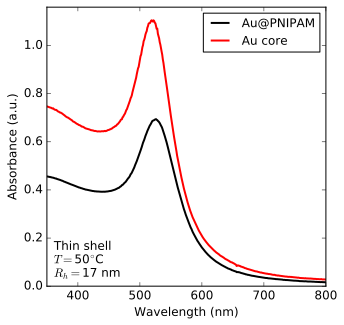

In [4]:
print('Sample spectrum')
print('===============')
def plotAndSave ():   
    pylab.cla()
    ## Selection ranges
    sampleNum, tempC = 0, 49
    wlMin, wlMax = 350, 800
    
    # data set 1
    label = 'Au@PNIPAM'
    color = 'black'
    aList = list(zip(dataLArray[:,-3],np.abs(tempC - dataLArray[:,-3])))
    dtype = [('T',float),('dT',float)]
    anArray = np.array(aList, dtype=dtype)
    tempC = np.sort(anArray, order='dT')[0][0]
    selection = (dataLArray[:,0] >= wlMin) & (dataLArray[:,0] <= wlMax) & (dataLArray[:,-3] == tempC) & (dataLArray[:,-1] == sampleNum)
    plotArray = dataLArray[selection]
    x, y = plotArray[:,0], plotArray[:,1]
    Rhnm = plotArray[0,-2]
    xs, ys, labels, colors = [x], [y], [label], [color]
    
    # data set 2
    label = 'Au core'
    color = 'red'
    selection = (spectrumCore[:,0] >= wlMin) & (spectrumCore[:,0] <= wlMax)
    plotArray = spectrumCore[selection]
    x, y = plotArray[:,0], plotArray[:,1]
    xs.append(x), ys.append(y), labels.append(label), colors.append(color)
    
    ## Plot lines & set limits
    nSets = len(xs)
    for setNum in range(nSets):
        pylab.plot(xs[setNum], ys[setNum], label=labels[setNum], color=colors[setNum], linewidth=2)
    x, y = [], []
    for setNum in range(nSets):
        for i in range(len(xs[setNum])): 
            x.append(xs[setNum][i]); y.append(ys[setNum][i])
    xLimits = [np.amin(x), np.amax(x)]
    yLimits = [np.amin(y), np.amax(y)]
    dx, dy = abs(xLimits[1]-xLimits[0]), abs(yLimits[1]-yLimits[0])
    xLimits = [np.amin(x), np.amax(x)]
    yLimits = [np.amin(y)*0, np.amax(y)+ 0.05*dy]
    dx, dy = abs(xLimits[1]-xLimits[0]), abs(yLimits[1]-yLimits[0])
    
    ## Specific format options
    pylab.xlabel("Wavelength (nm)")
    pylab.ylabel("Absorbance (a.u.)")
    figText = (['Thin','Med.','Thick'][sampleNum]+' shell'+'\n'
        +'$T=$'+str(int(tempC))+'$^{\circ}$C'+'\n'
        + '$R_h=$'+str(int(Rhnm))+' nm')
    pylab.text(xLimits[0]+0.025*dx, yLimits[0]+0.025*dy, figText, verticalalignment='bottom', horizontalalignment='left')
    pylab.legend(loc='upper right', fontsize=12)
    
    ## More general format options
    #aspectRatio = dx/dy
    #figWidthcm = [8.46, 17.78][0] # ACS 1- and 2- column sizes
    #figSizein = [figWidthcm/2.54, aspectRatio*figWidthcm/2.54]
    #pylab.rcParams['figure.figsize'] = (6,6)
    #pylab.subplot(111)
    #pylab.rcParams.update({'font.size': 14})
    #pylab.axes().set_aspect(aspectRatio)
    pylab.xlim(xLimits[0], xLimits[1])
    pylab.ylim(yLimits[0], yLimits[1])
    pylab.locator_params(nbins=7)
    
    ## Save and display
    timestamp = ('{:%Y%m%d}'.format(datetime.datetime.now()))
    exportFormat = '.svg'
    filename = "graphics/" + timestamp + "_sample-spectrum" + exportFormat
    # pylab.savefig(filename); print("Exported to:\n", filename)
    pylab.show()
    
plotAndSave() 


### Cross-linked PNIPAM

In [5]:
print("Import and organize data")
print("========================")
folderName = 'data_20160906'
fileNames = []
print("Importing data in folder",folderName,"...")
for file in os.listdir(folderName):
    #if file.endswith('.dat'): 
        fileNames.append(file)
fileNames = np.sort(fileNames)
spectraXTemps = []
def importData(fileName):
    print("  *",fileName)
    headerLines = 3
    if (fileName == 'temperature-calibration.dat'): 
        headerLines = 2
    if (fileName == 'Au-xPNIPAM-long.dat'
          or fileName == 'Au-xPNIPAM-medium.dat'
          or fileName == 'Au-xPNIPAM-short.dat'): 
        temps = np.genfromtxt(folderName+'/'+fileName, delimiter='\t', skip_header=2, max_rows=1)[1:-1]
        temps = temps.tolist()
        spectraXTemps.append(temps)
        #print(temps)

    tempData = np.genfromtxt(folderName+'/'+fileName, delimiter='\t', skip_header=headerLines)
    # print(tempData)
    return tempData
data = list(map(importData,fileNames))

tempConvert = interpolate.interp1d(data[-1][:,0], data[-1][:,1], kind="cubic")
aListOfLists = spectraXTemps
spectraXTemps = []
for i in range(3):
    aList = []
    for ii in range(len(aListOfLists[i])):
        newTemp = (tempConvert(aListOfLists[i][ii])).tolist()
        aList.append(newTemp)
    spectraXTemps.append(aList)

# Last column indicates sample shell thickness:
# 5 = long (thick)
# 4 = medium
# 3 = short (thin)
print("Oganizing data ...")
dataXList = []
spectraXRhnms = []
for i in range(3):
    sampleNum = int(3 + 2-i)
    dlsData = data[1+2*i]
    spectraData0 = data[1+2*i+1]
    temps = spectraXTemps[i]
    hydroRs = []
    for T in temps:
        aList = list(zip(dlsData[:,0], dlsData[:,1], np.abs(dlsData[:,0] - T)))
        dtype = [('T',float), ('Rh',float), ('dT',float)]
        anArray = np.array(aList, dtype=dtype)
        anArray = np.sort(anArray, order='dT')[0:3]
        subset = []
        for pt in anArray:
            subset.append(pt[1])
        rh = np.mean(subset)
        hydroRs.append(rh)
    for ii in range(len(temps)):
        for iii in range(len(spectraData0)):
            dataPoint = [ spectraData0[iii,0], spectraData0[iii,ii+1], temps[ii], hydroRs[ii].tolist(), sampleNum ]
            dataXList.append(dataPoint)
            spectraXRhnms.append(hydroRs)
dataXArray = np.asarray(dataXList)
print("  * extrapolate hydrodynamic radius from DLS to UV-Vis temps")
print("  * organized as [ wl-nm, abs, temp, Rh, sample-# ]")
print("  * sample 5 = thick shell, 4 = medium, 3 = thin")

# Au cores only
spectrumXCore = data[0]
print("  * core alone sorted separately")

print("Done.")

Import and organize data
Importing data in folder data_20160906 ...
  * Au-core-only-for-xPNIPAM.dat
  * Au-xPNIPAM-long-hydr-radius.dat
  * Au-xPNIPAM-long.dat
  * Au-xPNIPAM-medium-hydr-radius.dat
  * Au-xPNIPAM-medium.dat
  * Au-xPNIPAM-short-hydr-radius.dat
  * Au-xPNIPAM-short.dat
  * temperature-calibration.dat
Oganizing data ...
  * extrapolate hydrodynamic radius from DLS to UV-Vis temps
  * organized as [ wl-nm, abs, temp, Rh, sample-# ]
  * sample 5 = thick shell, 4 = medium, 3 = thin
  * core alone sorted separately
Done.


A spectrum plot to make sure everything imported correctly.

Sample spectrum


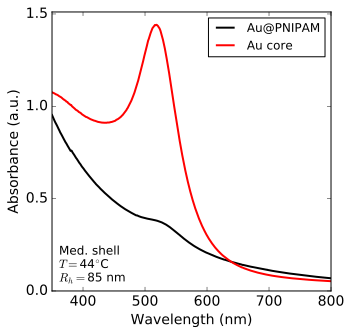

In [6]:
print('Sample spectrum')
print('===============')
def plotAndSave ():   
    ## Selection ranges
    sampleNum, tempC = 4, 45
    wlMin, wlMax = 350, 800
    
    # data set 1
    label = 'Au@PNIPAM'
    color = 'black'
    aList = list(zip(dataXArray[:,-3],np.abs(tempC - dataXArray[:,-3])))
    dtype = [('T',float),('dT',float)]
    anArray = np.array(aList, dtype=dtype)
    tempC = np.sort(anArray, order='dT')[0][0]
    selection = (dataXArray[:,0] >= wlMin) & (dataXArray[:,0] <= wlMax) & (dataXArray[:,-3] == tempC) & (dataXArray[:,-1] == sampleNum)
    plotArray = dataXArray[selection]
    Rhnm = plotArray[0,-2]
    x, y = plotArray[:,0], plotArray[:,1]
    xs, ys, labels, colors = [x], [y], [label], [color]
    
    # data set 2
    label = 'Au core'
    color = 'red'
    selection = (spectrumXCore[:,0] >= wlMin) & (spectrumXCore[:,0] <= wlMax)
    plotArray = spectrumXCore[selection]
    x, y = plotArray[:,0], plotArray[:,1]
    xs.append(x), ys.append(y), labels.append(label), colors.append(color)
    
    ## Plot lines & set limits
    nSets = len(xs)
    for setNum in range(nSets):
        pylab.plot(xs[setNum], ys[setNum], label=labels[setNum], color=colors[setNum], linewidth=2)
    x, y = [], []
    for setNum in range(nSets):
        for i in range(len(xs[setNum])): 
            x.append(xs[setNum][i]); y.append(ys[setNum][i])
    xLimits = [np.amin(x), np.amax(x)]
    yLimits = [np.amin(y), np.amax(y)]
    dx, dy = abs(xLimits[1]-xLimits[0]), abs(yLimits[1]-yLimits[0])
    xLimits = [np.amin(x), np.amax(x)]
    yLimits = [np.amin(y)*0, np.amax(y)+ 0.05*dy]
    dx, dy = abs(xLimits[1]-xLimits[0]), abs(yLimits[1]-yLimits[0])
    
    ## Specific format options
    pylab.xlabel("Wavelength (nm)")
    pylab.ylabel("Absorbance (a.u.)")
    figText = (['Thin','Med.','Thick','Thin','Med.','Thick'][sampleNum]+' shell'+'\n'
        +'$T=$'+str(int(tempC))+'$^{\circ}$C'+'\n'
        + '$R_h=$'+str(int(Rhnm))+' nm')
    pylab.text(xLimits[0]+0.025*dx, yLimits[0]+0.025*dy, figText, verticalalignment='bottom', horizontalalignment='left')
    pylab.legend(loc='upper right', fontsize=12)
    
    ## More general format options
    aspectRatio = dx/dy
    figWidthcm = [8.46, 17.78][0] # ACS 1- and 2- column sizes
    figSizein = [figWidthcm/2.54, aspectRatio*figWidthcm/2.54]
    fig = pylab.figure(1, figsize=(figSizein[0],figSizein[1]))
    pylab.subplot(111)
    pylab.rcParams.update({'font.size': 14})
    pylab.axes().set_aspect(aspectRatio)
    pylab.xlim(xLimits[0], xLimits[1])
    pylab.ylim(yLimits[0], yLimits[1])
    pylab.locator_params(nbins=7)
    
    ## Save and display
    timestamp = ('{:%Y%m%d}'.format(datetime.datetime.now()))
    exportFormat = '.svg'
    filename = "graphics/" + timestamp + "_sample-spectrum" + exportFormat
    # pylab.savefig(filename); print("Exported to:\n", filename)
    pylab.show()
    
plotAndSave() 


### Combine data sets

In [7]:
dataList = dataLArray.tolist()
for i in range(len(dataXArray)): dataList.append(dataXArray[i])
dataArray = np.asarray(dataList)

spectraCores = np.array([spectrumCore, spectrumXCore])
coreRnms = [17/2, 13.2/2]

spectraTemps = []
spectraRhnms = []
for sampleNum in range(6):
    print(sampleNum,':')
    selection = (dataArray[:,-1] == sampleNum)
    temps = np.unique( (dataArray[selection])[:,-3] )
    Rhnms = []
    for T in temps:
        selection = (dataArray[:,-1] == sampleNum) & (dataArray[:,-3] == T)
        RhOfT = np.unique( (dataArray[selection])[:,-2] ) 
        print('  ', T, RhOfT[0])
        Rhnms.append( RhOfT[0] )
    Rhnms = np.asarray(Rhnms)
    print('(',temps.size, 'x',Rhnms.size,')')
    spectraTemps.append(temps)
    spectraRhnms.append(Rhnms)
spectraTemps = np.asarray(spectraTemps)
spectraRhnms = np.asarray(spectraRhnms)

0 :
   15.0 24.7666666667
   20.0 23.1888888889
   25.0 23.8
   27.0 23.8222222222
   29.0 23.4
   31.0 21.8111111111
   33.0 20.6666666667
   35.0 20.9333333333
   40.0 18.5777777778
   45.0 18.1222222222
   50.0 17.6555555556
   55.0 18.6222222222
   60.0 17.8777777778
( 13 x 13 )
1 :
   15.0 43.2
   20.0 41.8888888889
   25.0 39.2777777778
   27.0 37.9888888889
   29.0 36.9111111111
   31.0 33.8888888889
   33.0 29.5555555556
   35.0 28.0555555556
   40.0 27.2333333333
   45.0 26.7777777778
   50.0 26.7611111111
   55.0 26.0111111111
   60.0 26.4777777778
( 13 x 13 )
2 :
   15.0 65.0222222222
   20.0 64.1555555556
   25.0 61.7444444444
   27.0 59.0555555556
   29.0 56.4222222222
   31.0 53.1111111111
   33.0 45.8333333333
   35.0 42.6111111111
   40.0 38.0222222222
   45.0 39.4333333333
   50.0 39.1333333333
   55.0 39.2888888889
( 12 x 12 )
3 :
   7.65 82.1502847344
   9.96 81.5246415465
   13.81 79.7910253029
   17.66 78.1176669192
   21.51 75.960939485
   25.36 71.3064301507
   2

## Import SLS data

In [8]:
print("Import and organize data")
print("========================")
print("X-linked PNIPAM: ")
folderName = 'data_20160914'
fileNames = []
print("Importing data in folder",folderName,"...")
for file in os.listdir(folderName):
    #if file.endswith('.dat'): 
        fileNames.append(file)
fileNames = np.sort(fileNames)
slsNames = []
slsTemps = []
def importData(fileName):
    print("  *",fileName)
    headerLines = 3

    columnNames = np.genfromtxt(folderName+'/'+fileName, 
                                delimiter='\t', dtype=str, 
                                comments='\\', skip_header=0, max_rows=1)[0:-1]
    slsNames.append(columnNames.tolist())
    temp = np.genfromtxt(folderName+'/'+fileName, delimiter='\t', dtype=str, 
                                comments='\\', skip_header=2, max_rows=1)[2]
    temp = float(temp)
    slsTemps.append(temp)
    #print(columnNames)
    temporaryData = np.genfromtxt(folderName+'/'+fileName, delimiter='\t', skip_header=headerLines)
    return temporaryData
slsData = list(map(importData,fileNames))
print('Columns:',slsNames[2])
print('Collapsed-state reference samples 4-5')
slsIvsqRefSample4 = slsData[3][:,[1,2]]
slsIvsqRefSample5 = slsData[1][:,[1,2]]
print(' variables \t\'slsIvsqRefSample4\',\n  \t\t\'slsIvsqRefSample5\'')
print('Swollen-states samples 3-5')
slsIvsqSwollenSample3 = slsData[-1][:,[1,2]]
slsIvsqSwollenSample4 = slsData[2][:,[1,2]]
slsIvsqSwollenSample5 = slsData[0][:,[1,2]]
print(' variables \t\'slsIvsqSwollenSample3\',\n  \t\t\'slsIvsqSwollenSample4\',\n  \t\t\'slsIvsqSwollenSample5\'')


Import and organize data
X-linked PNIPAM: 
Importing data in folder data_20160914 ...
  * Au-xPNIPAM-long-SLS-20degreeC.dat
  * Au-xPNIPAM-long-SLS-50degreeC.dat
  * Au-xPNIPAM-medium-SLS-20degreeC.dat
  * Au-xPNIPAM-medium-SLS-50degreeC.dat
  * Au-xPNIPAM-short-SLS-20degreeC.dat
Columns: ['theta', 'q', 'I(q)', 'I(q)-error']
Collapsed-state reference samples 4-5
 variables 	'slsIvsqRefSample4',
  		'slsIvsqRefSample5'
Swollen-states samples 3-5
 variables 	'slsIvsqSwollenSample3',
  		'slsIvsqSwollenSample4',
  		'slsIvsqSwollenSample5'


# Initial plots

## Spectra line plots

### Basic plots

All spectra
 with Au core in red for reference
Exported to:
 graphics/20170320_spectrum-L1-thn-T=15.0C.svg


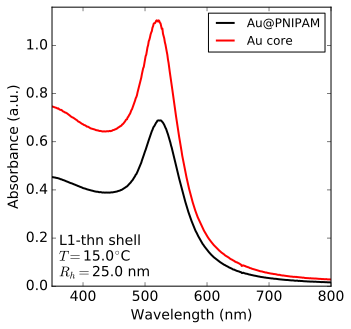

Exported to:
 graphics/20170320_spectrum-L1-thn-T=15.0C.svg


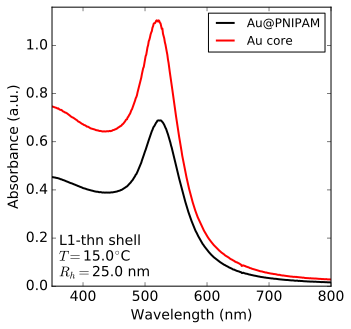

Exported to:
 graphics/20170320_spectrum-L1-thn-T=20.0C.svg


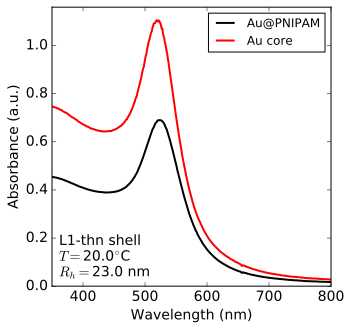

Exported to:
 graphics/20170320_spectrum-L1-thn-T=25.0C.svg


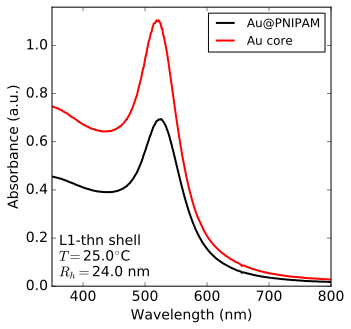

Exported to:
 graphics/20170320_spectrum-L1-thn-T=29.0C.svg


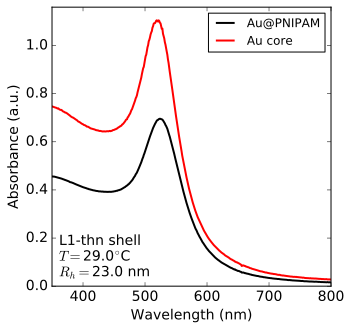

Exported to:
 graphics/20170320_spectrum-L1-thn-T=35.0C.svg


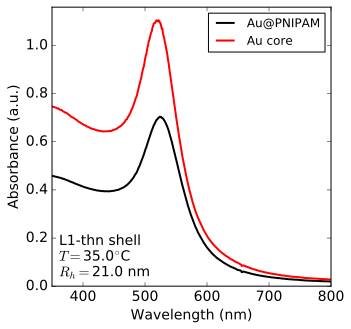

Exported to:
 graphics/20170320_spectrum-L1-thn-T=40.0C.svg


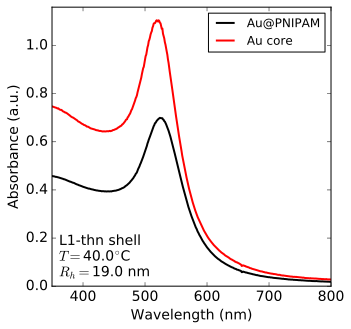

Exported to:
 graphics/20170320_spectrum-L1-thn-T=45.0C.svg


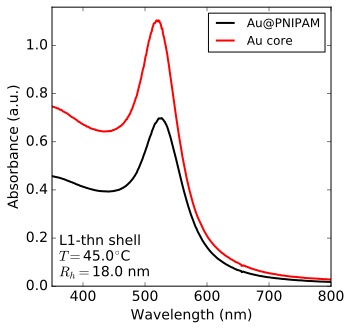

Exported to:
 graphics/20170320_spectrum-L1-thn-T=50.0C.svg


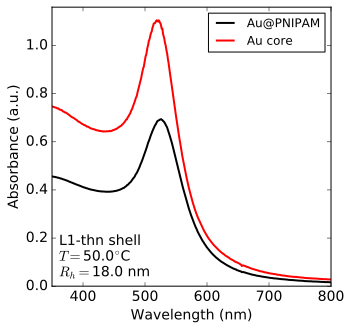

Exported to:
 graphics/20170320_spectrum-L1-thn-T=55.0C.svg


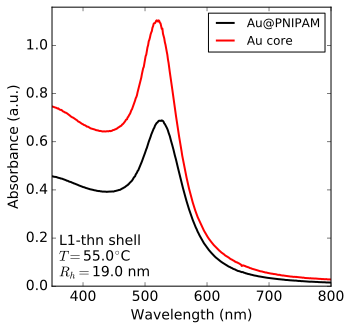

Exported to:
 graphics/20170320_spectrum-L2-med-T=15.0C.svg


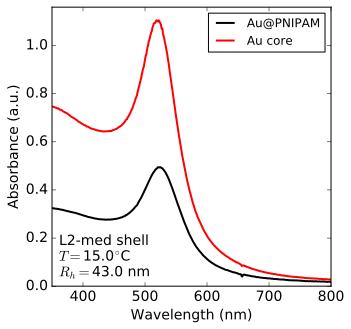

Exported to:
 graphics/20170320_spectrum-L2-med-T=15.0C.svg


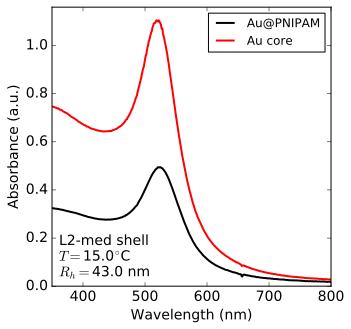

Exported to:
 graphics/20170320_spectrum-L2-med-T=20.0C.svg


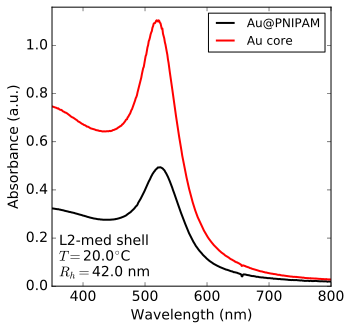

Exported to:
 graphics/20170320_spectrum-L2-med-T=25.0C.svg


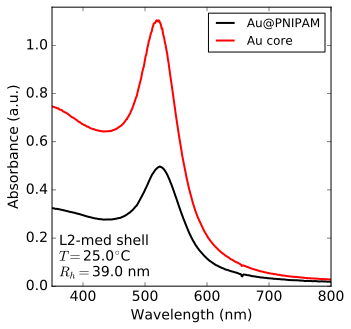

Exported to:
 graphics/20170320_spectrum-L2-med-T=29.0C.svg


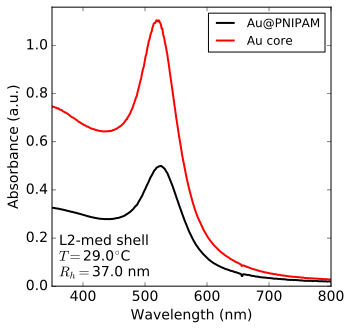

Exported to:
 graphics/20170320_spectrum-L2-med-T=35.0C.svg


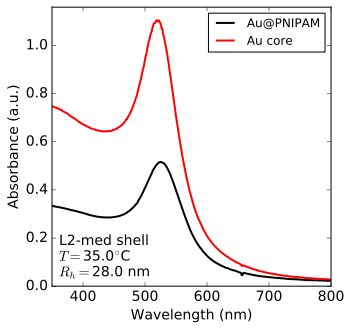

Exported to:
 graphics/20170320_spectrum-L2-med-T=40.0C.svg


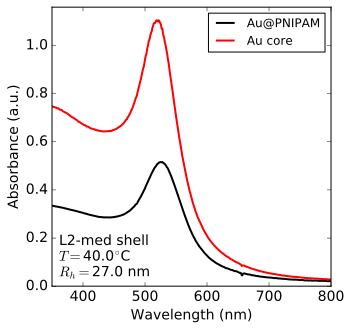

Exported to:
 graphics/20170320_spectrum-L2-med-T=45.0C.svg


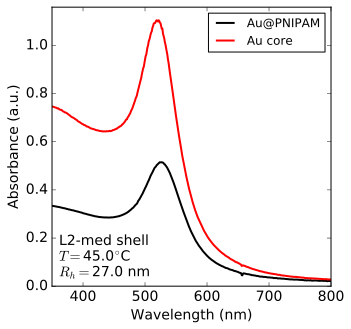

Exported to:
 graphics/20170320_spectrum-L2-med-T=50.0C.svg


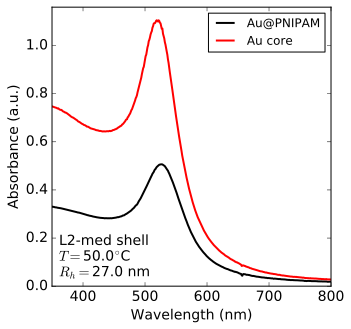

Exported to:
 graphics/20170320_spectrum-L2-med-T=55.0C.svg


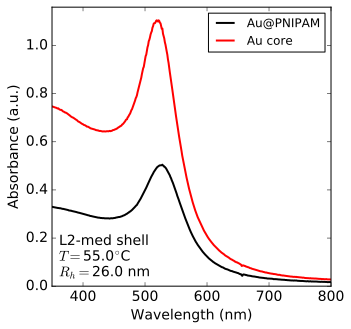

Exported to:
 graphics/20170320_spectrum-L3-thk-T=15.0C.svg


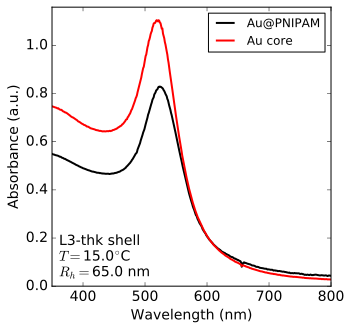

Exported to:
 graphics/20170320_spectrum-L3-thk-T=15.0C.svg


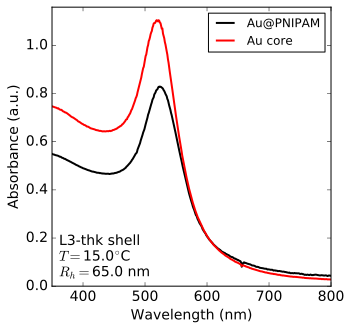

Exported to:
 graphics/20170320_spectrum-L3-thk-T=20.0C.svg


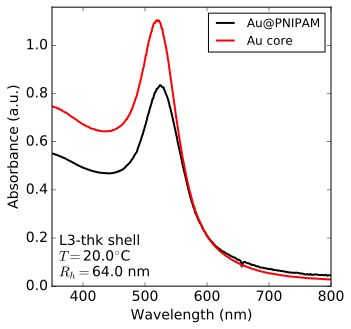

Exported to:
 graphics/20170320_spectrum-L3-thk-T=25.0C.svg


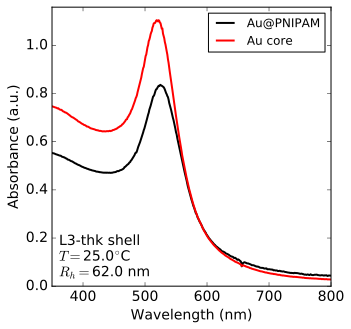

Exported to:
 graphics/20170320_spectrum-L3-thk-T=29.0C.svg


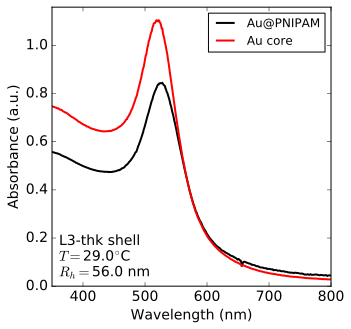

Exported to:
 graphics/20170320_spectrum-L3-thk-T=35.0C.svg


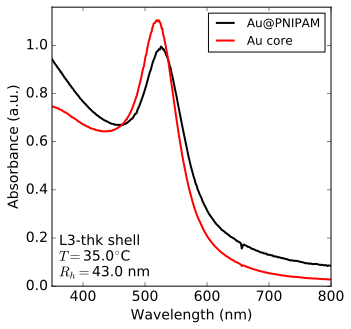

Exported to:
 graphics/20170320_spectrum-L3-thk-T=40.0C.svg


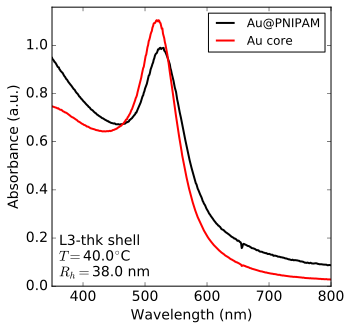

Exported to:
 graphics/20170320_spectrum-L3-thk-T=45.0C.svg


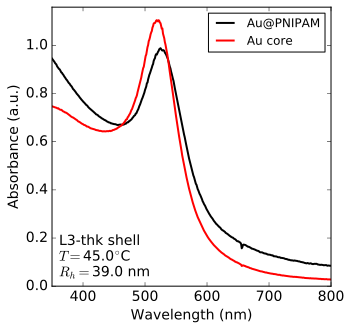

Exported to:
 graphics/20170320_spectrum-L3-thk-T=50.0C.svg


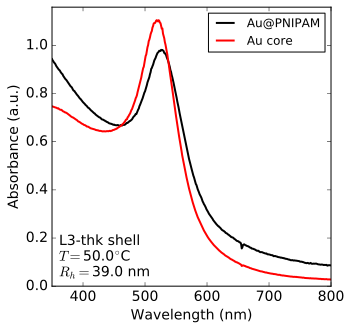

Exported to:
 graphics/20170320_spectrum-L3-thk-T=55.0C.svg


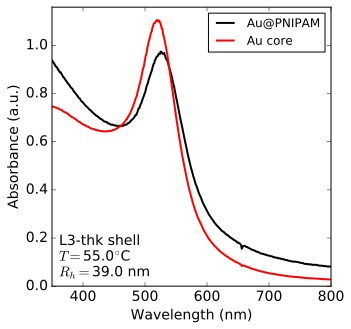

Exported to:
 graphics/20170320_spectrum-X1-thn-T=10.0C.svg


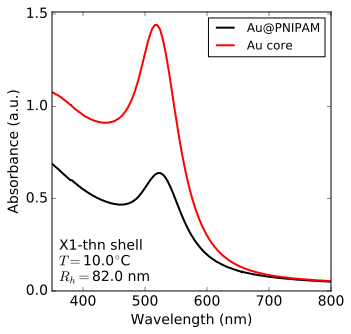

Exported to:
 graphics/20170320_spectrum-X1-thn-T=13.8C.svg


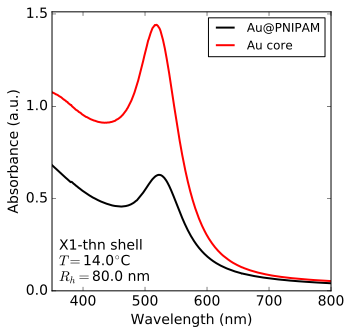

Exported to:
 graphics/20170320_spectrum-X1-thn-T=21.5C.svg


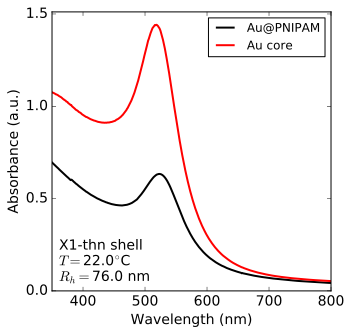

Exported to:
 graphics/20170320_spectrum-X1-thn-T=25.4C.svg


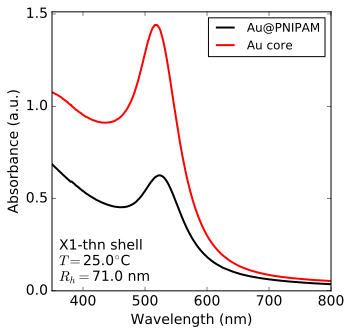

Exported to:
 graphics/20170320_spectrum-X1-thn-T=30.0C.svg


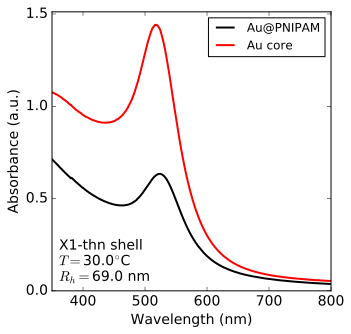

Exported to:
 graphics/20170320_spectrum-X1-thn-T=33.8C.svg


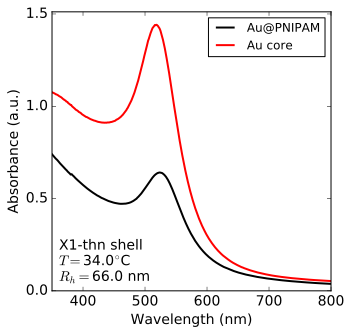

Exported to:
 graphics/20170320_spectrum-X1-thn-T=40.8C.svg


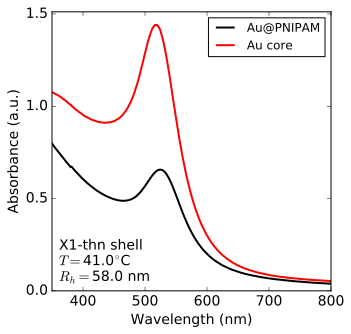

Exported to:
 graphics/20170320_spectrum-X1-thn-T=44.6C.svg


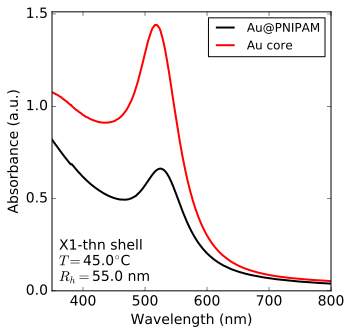

Exported to:
 graphics/20170320_spectrum-X1-thn-T=48.5C.svg


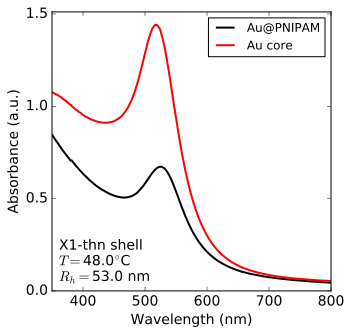

Exported to:
 graphics/20170320_spectrum-X1-thn-T=56.2C.svg


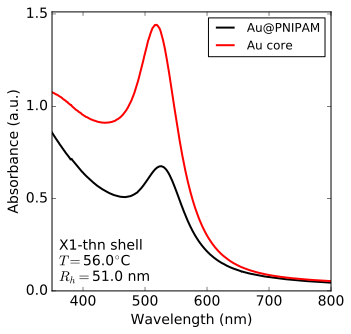

Exported to:
 graphics/20170320_spectrum-X2-med-T=10.0C.svg


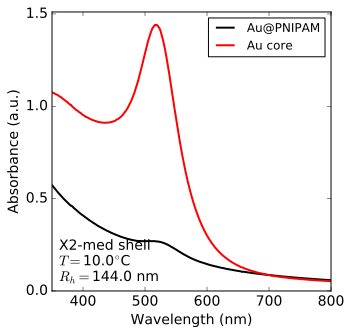

Exported to:
 graphics/20170320_spectrum-X2-med-T=13.8C.svg


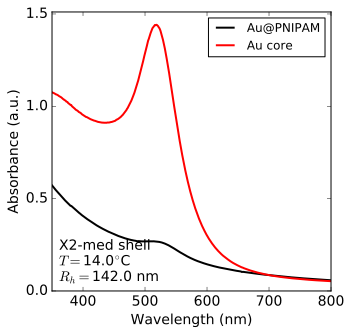

Exported to:
 graphics/20170320_spectrum-X2-med-T=21.5C.svg


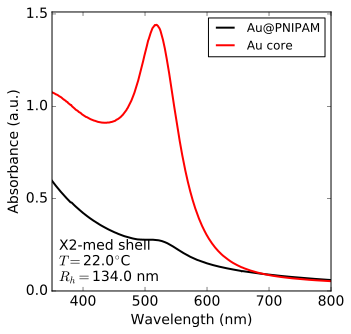

Exported to:
 graphics/20170320_spectrum-X2-med-T=25.4C.svg


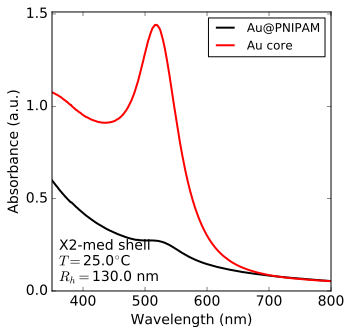

Exported to:
 graphics/20170320_spectrum-X2-med-T=30.0C.svg


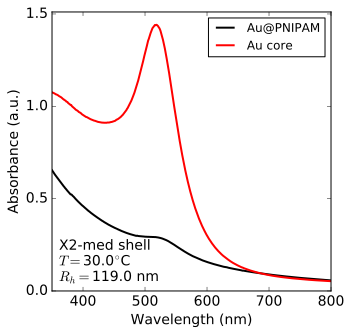

Exported to:
 graphics/20170320_spectrum-X2-med-T=33.8C.svg


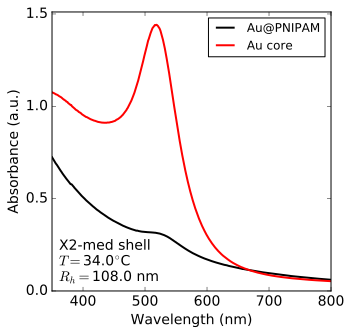

Exported to:
 graphics/20170320_spectrum-X2-med-T=40.8C.svg


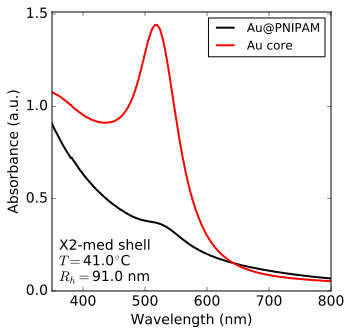

Exported to:
 graphics/20170320_spectrum-X2-med-T=44.6C.svg


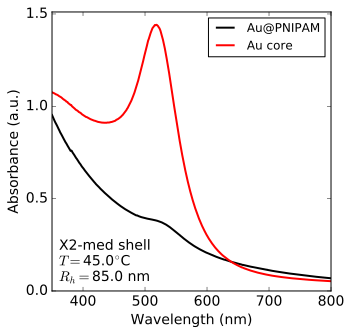

Exported to:
 graphics/20170320_spectrum-X2-med-T=48.5C.svg


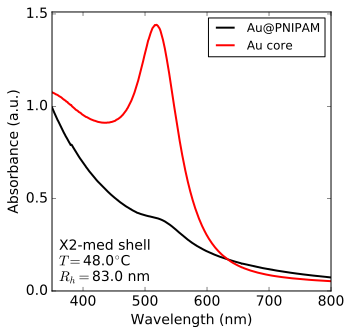

Exported to:
 graphics/20170320_spectrum-X2-med-T=56.2C.svg


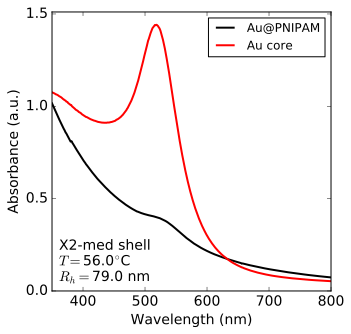

Exported to:
 graphics/20170320_spectrum-X3-thk-T=10.0C.svg


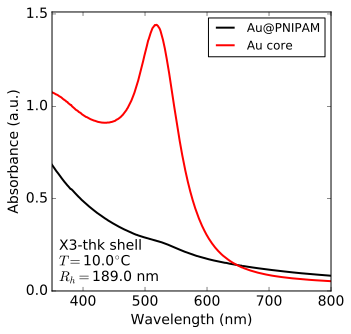

Exported to:
 graphics/20170320_spectrum-X3-thk-T=13.8C.svg


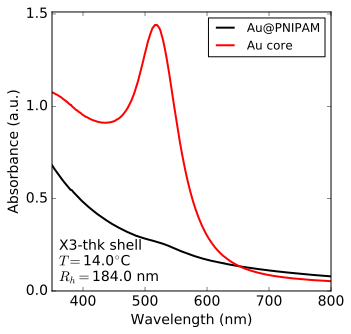

Exported to:
 graphics/20170320_spectrum-X3-thk-T=21.5C.svg


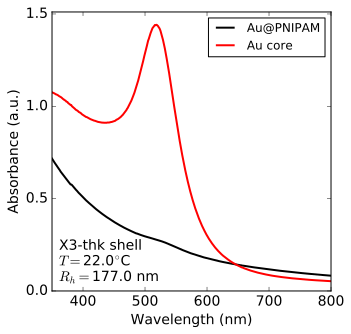

Exported to:
 graphics/20170320_spectrum-X3-thk-T=25.4C.svg


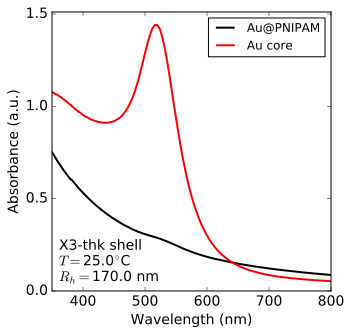

Exported to:
 graphics/20170320_spectrum-X3-thk-T=30.0C.svg


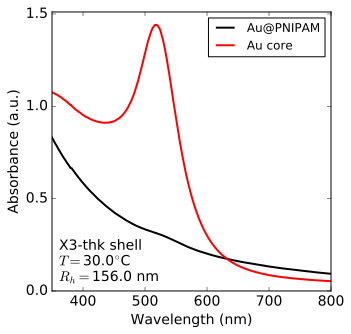

Exported to:
 graphics/20170320_spectrum-X3-thk-T=33.8C.svg


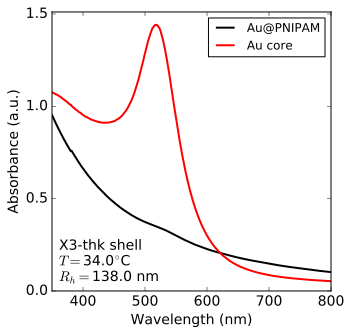

Exported to:
 graphics/20170320_spectrum-X3-thk-T=40.8C.svg


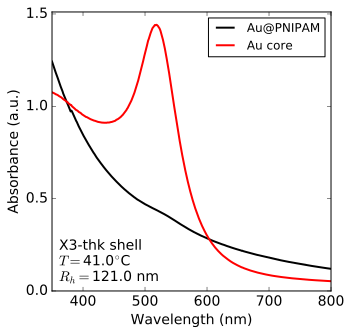

Exported to:
 graphics/20170320_spectrum-X3-thk-T=44.6C.svg


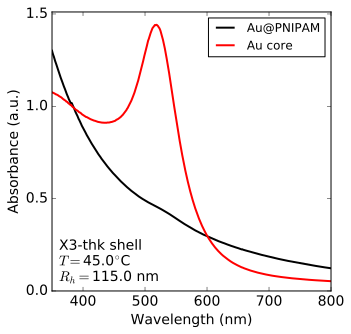

Exported to:
 graphics/20170320_spectrum-X3-thk-T=48.5C.svg


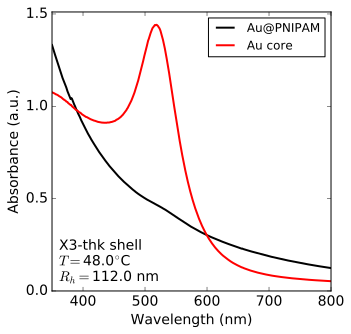

Exported to:
 graphics/20170320_spectrum-X3-thk-T=56.2C.svg


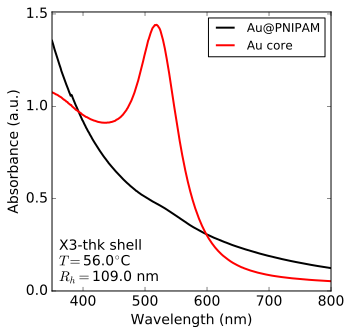

In [10]:
print('All spectra')
print('===========')
print(' with Au core in red for reference')
def plotAndSave (sampleNum, tempC):   
    spectrumNames = ['L1-thn','L2-med','L3-thk','X1-thn','X2-med','X3-thk']
    ## Selection ranges
    wlMin, wlMax = 350, 800
    
    spectrumCore, tempList, sampleType = [], [], ''
    if sampleNum < 3: 
        spectrumCore = spectraCores[0]
    else: 
        spectrumCore = spectraCores[1]
    tempList = spectraTemps[sampleNum]
    RhnmList = spectraRhnms[sampleNum]
    
    # data set 1
    label = 'Au@PNIPAM'
    color = 'black'
    aList = list(zip(tempList, RhnmList, np.abs(tempC - tempList)))
    dtype = [('T',float), ('Rh',float), ('dT',float)]
    anArray = np.array(aList, dtype=dtype)
    closestTemp = np.sort(anArray, order='dT')[0]
    tempC, Rhnm = closestTemp[0], closestTemp[1]
    selection = (dataArray[:,0] >= wlMin) & (dataArray[:,0] <= wlMax) & (dataArray[:,-3] == tempC) & (dataArray[:,-1] == sampleNum)
    plotArray = dataArray[selection]
    x, y = plotArray[:,0], plotArray[:,1]
    xs, ys, labels, colors = [x], [y], [label], [color]
    
    # data set 2
    label = 'Au core'
    color = 'red'
    selection = (spectrumCore[:,0] >= wlMin) & (spectrumCore[:,0] <= wlMax)
    plotArray = spectrumCore[selection]
    x, y = plotArray[:,0], plotArray[:,1]
    xs.append(x), ys.append(y), labels.append(label), colors.append(color)
    
    ## Plot lines & set limits
    nSets = len(xs)
    for setNum in range(nSets):
        pylab.plot(xs[setNum], ys[setNum], label=labels[setNum], color=colors[setNum], linewidth=2)
    x, y = [], []
    for setNum in range(nSets):
        for i in range(len(xs[setNum])): 
            x.append(xs[setNum][i]); y.append(ys[setNum][i])
    xLimits = [np.amin(x), np.amax(x)]
    yLimits = [np.amin(y), np.amax(y)]
    dx, dy = abs(xLimits[1]-xLimits[0]), abs(yLimits[1]-yLimits[0])
    xLimits = [np.amin(x), np.amax(x)]
    yLimits = [np.amin(y)*0, np.amax(y)+ 0.05*dy]
    dx, dy = abs(xLimits[1]-xLimits[0]), abs(yLimits[1]-yLimits[0])
    
    ## Specific format options
    pylab.xlabel("Wavelength (nm)")
    pylab.ylabel("Absorbance (a.u.)")
    figText = (spectrumNames[sampleNum]+' shell'+'\n'
        +'$T=$'+str(round(tempC))+'$^{\circ}$C'+'\n'
        + '$R_h=$'+str(round(Rhnm))+' nm')
    pylab.text(xLimits[0]+0.025*dx, yLimits[0]+0.025*dy, figText, verticalalignment='bottom', horizontalalignment='left')
    pylab.legend(loc='upper right', fontsize=12)
    
    ## More general format options
    aspectRatio = dx/dy
    figWidthcm = [8.46, 17.78][0] # ACS 1- and 2- column sizes
    figSizein = [figWidthcm/2.54, aspectRatio*figWidthcm/2.54]
    fig = pylab.figure(1, figsize=(figSizein[0],figSizein[1]))
    pylab.subplot(111)
    pylab.rcParams.update({'font.size': 14})
    pylab.axes().set_aspect(aspectRatio)
    pylab.xlim(xLimits[0], xLimits[1])
    pylab.ylim(yLimits[0], yLimits[1])
    pylab.locator_params(nbins=7)
    
    ## Save and display
    timestamp = ('{:%Y%m%d}'.format(datetime.datetime.now()))
    exportFormat = '.svg'
    identifier = ("_spectrum-"
                  + spectrumNames[sampleNum]
                  + '-T='+str(0.1*round(tempC*10))+'C')
    filename = "graphics/" + timestamp + identifier + exportFormat
    pylab.savefig(filename); print("Exported to:\n", filename)
    pylab.show()
    
for sampleNum in range(6):
    for tempC in range(10,60,5):
        plotAndSave(sampleNum, tempC) 


In [ ]:
print('All spectra')
print('===========')
def plotAndSave (spectrumNum):   
    spectrumNames = ['L0-cor','L1-thn','L2-med','L3-thk','X0-cor','X1-thn','X2-med','X3-thk']
    sampleNum = spectrumNum - 1
    if sampleNum < 0: sampleNum = 0
    if spectrumNum == 4: sampleNum = 3
    if spectrumNum > 4: sampleNum = spectrumNum - 2
        
    ## Selection ranges
    wlMin, wlMax = 350, 800
    
    spectrumCore, tempList, sampleType = [], [], ''
    if sampleNum < 3: 
        spectrumCore = spectraCores[0]
    else: 
        spectrumCore = spectraCores[1]
    tempList = spectraTemps[sampleNum]
    RhnmList = spectraRhnms[sampleNum]
    
    xs, ys, labels, colors = [], [], [], []
    
    # data set 1
    Rhsnm = np.linspace(np.max(RhnmList), np.min(RhnmList),11)
    colorList = pylab.cm.Blues(np.linspace(0.3,1,len(Rhsnm)))
    for tempNum in range(len(Rhsnm)):
        Rhnm = Rhsnm[tempNum]
        color = colorList[tempNum]
        aList = list(zip(tempList, RhnmList, np.abs(Rhnm - RhnmList)))
        dtype = [('T',float), ('Rh',float), ('dRh',float)]
        anArray = np.array(aList, dtype=dtype)
        closestTemp = np.sort(anArray, order='dRh')[0]
        tempC, Rhnm = closestTemp[0], closestTemp[1]
        label = str(0.1*np.round(tempC*10)) + '$^{\circ}$C, ' + str(0.1*np.round(Rhnm*10)) + ' nm'
        selection = (dataArray[:,0] >= wlMin) & (dataArray[:,0] <= wlMax) & (dataArray[:,-3] == tempC) & (dataArray[:,-1] == sampleNum)
        plotArray = dataArray[selection]
        x, y = plotArray[:,0], plotArray[:,1]
        xs.append(x), ys.append(y), labels.append(label), colors.append(color)
    
    # data set 2
    label = spectrumNames[spectrumNum]
    color = 'black'
    selection = (spectrumCore[:,0] >= wlMin) & (spectrumCore[:,0] <= wlMax)
    plotArray = spectrumCore[selection]
    x, y = plotArray[:,0], plotArray[:,1]
    y = y/np.max(y)
    xs.append(x), ys.append(y), labels.append(label), colors.append(color)
    
    ## Plot lines & set limits
    nSets = len(xs) - 1
    if ((spectrumNum == 0) | (spectrumNum == 4)):
        pylab.plot(xs[-1], ys[-1], label=labels[-1], color=colors[-1], linewidth=2)
    else:
        for setNum in range(nSets):
            pylab.plot(xs[setNum], ys[setNum], label=labels[setNum], color=colors[setNum], linewidth=2)
    x, y = [], []
    for setNum in range(nSets):
        for i in range(len(xs[setNum])): 
            x.append(xs[setNum][i]); y.append(ys[setNum][i])
    if ((spectrumNum == 0) | (spectrumNum == 4)): x, y = xs[-1], ys[-1]
    xLimits = [np.amin(x), np.amax(x)]
    yLimits = [np.amin(y), np.amax(y)]
    dx, dy = abs(xLimits[1]-xLimits[0]), abs(yLimits[1]-yLimits[0])
    xLimits = [np.amin(x), np.amax(x)]
    yLimits = [np.amin(y)*0, np.amax(y)+ 0.05*dy]
    dx, dy = abs(xLimits[1]-xLimits[0]), abs(yLimits[1]-yLimits[0])
    
    ## Specific format options
    pylab.xlabel("Wavelength (nm)")
    pylab.ylabel("Extinction (normalized)")
    figText = (spectrumNames[spectrumNum])
    pylab.text(xLimits[0]+0.025*dx, yLimits[0]+0.025*dy, figText, verticalalignment='bottom', horizontalalignment='left')
    pylab.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), fontsize=12)
    
    ## More general format options
    aspectRatio = dx/dy
    figWidthcm = [8.46, 17.78][0] # ACS 1- and 2- column sizes
    figSizein = [figWidthcm/2.54, aspectRatio*figWidthcm/2.54]
    #fig = pylab.figure(1, figsize=(figSizein[0],figSizein[1]))
    #pylab.subplot(111)
    pylab.rcParams.update({'font.size': 14})
    pylab.axes().set_aspect(aspectRatio)
    pylab.xlim(xLimits[0], xLimits[1])
    pylab.ylim(yLimits[0], yLimits[1])
    pylab.locator_params(nbins=7)
    
    ## Save and display
    timestamp = ('{:%Y%m%d}'.format(datetime.datetime.now()))
    exportFormat = '.svg'
    identifier = ("_spectrum-"
                  + spectrumNames[spectrumNum])
    filename = "graphics/" + timestamp + identifier + exportFormat
    pylab.savefig(filename); print("Exported to:\n", filename)
    pylab.show()
    
for spectrumNum in range(8):
    plotAndSave(spectrumNum) 


In [ ]:
print('All spectra')
print('===========')
def plotAndSave (spectrumNum):   
    spectrumNames = ['L0-cor','L1-thn','L2-med','L3-thk','X0-cor','X1-thn','X2-med','X3-thk']
    sampleNum = spectrumNum - 1
    if sampleNum < 0: sampleNum = 0
    if spectrumNum == 4: sampleNum = 3
    if spectrumNum > 4: sampleNum = spectrumNum - 2
        
    ## Selection ranges
    wlMin, wlMax = 350, 800
    
    spectrumCore, tempList, sampleType = [], [], ''
    if sampleNum < 3: 
        spectrumCore = spectraCores[0]
    else: 
        spectrumCore = spectraCores[1]
    tempList = spectraTemps[sampleNum]
    RhnmList = spectraRhnms[sampleNum]
    
    xs, ys, labels, colors = [], [], [], []
    
    # data set 1
    Rhsnm = np.linspace(np.max(RhnmList), np.min(RhnmList),11)
    colorList = pylab.cm.hot(np.linspace(0,0.6,len(Rhsnm)))
    for tempNum in range(len(Rhsnm)):
        Rhnm = Rhsnm[tempNum]
        color = colorList[tempNum]
        aList = list(zip(tempList, RhnmList, np.abs(Rhnm - RhnmList)))
        dtype = [('T',float), ('Rh',float), ('dRh',float)]
        anArray = np.array(aList, dtype=dtype)
        closestTemp = np.sort(anArray, order='dRh')[0]
        tempC, Rhnm = closestTemp[0], closestTemp[1]
        label = str(0.1*np.round(tempC*10)) + '$^{\circ}$C, ' + str(0.1*np.round(Rhnm*10)) + ' nm'
        selection = (dataArray[:,0] >= wlMin) & (dataArray[:,0] <= wlMax) & (dataArray[:,-3] == tempC) & (dataArray[:,-1] == sampleNum)
        plotArray = dataArray[selection]
        x, y = plotArray[:,0], plotArray[:,1]
        xs.append(x), ys.append(y), labels.append(label), colors.append(color)
    
    # data set 2
    label = spectrumNames[spectrumNum]
    color = 'black'
    selection = (spectrumCore[:,0] >= wlMin) & (spectrumCore[:,0] <= wlMax)
    plotArray = spectrumCore[selection]
    x, y = plotArray[:,0], plotArray[:,1]
    y = y/np.max(y)
    xs.append(x), ys.append(y), labels.append(label), colors.append(color)
    
    ## Plot lines & set limits
    nSets = len(xs) - 1
    if ((spectrumNum == 0) | (spectrumNum == 4)):
        pylab.plot(xs[-1], ys[-1], label=labels[-1], color=colors[-1], linewidth=2)
    else:
        for setNum in range(nSets):
            pylab.plot(xs[setNum], ys[setNum], label=labels[setNum], color=colors[setNum], linewidth=2)
    x, y = [], []
    for setNum in range(nSets):
        for i in range(len(xs[setNum])): 
            x.append(xs[setNum][i]); y.append(ys[setNum][i])
    if ((spectrumNum == 0) | (spectrumNum == 4)): x, y = xs[-1], ys[-1]
    xLimits = [np.amin(x), np.amax(x)]
    yLimits = [np.amin(y), np.amax(y)]
    dx, dy = abs(xLimits[1]-xLimits[0]), abs(yLimits[1]-yLimits[0])
    xLimits = [np.amin(x), np.amax(x)]
    yLimits = [np.amin(y)*0, np.amax(y)+ 0.05*dy]
    dx, dy = abs(xLimits[1]-xLimits[0]), abs(yLimits[1]-yLimits[0])
    
    ## Specific format options
    pylab.xlabel("Wavelength (nm)")
    pylab.ylabel("Extinction (normalized)")
    figText = (spectrumNames[spectrumNum])
    pylab.text(xLimits[0]+0.025*dx, yLimits[0]+0.025*dy, figText, verticalalignment='bottom', horizontalalignment='left')
    pylab.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), fontsize=12)
    
    ## More general format options
    aspectRatio = dx/dy
    figWidthcm = [8.46, 17.78][0] # ACS 1- and 2- column sizes
    figSizein = [figWidthcm/2.54, aspectRatio*figWidthcm/2.54]
    #fig = pylab.figure(1, figsize=(figSizein[0],figSizein[1]))
    #pylab.subplot(111)
    pylab.rcParams.update({'font.size': 14})
    pylab.axes().set_aspect(aspectRatio)
    pylab.xlim(xLimits[0], xLimits[1])
    pylab.ylim(yLimits[0], yLimits[1])
    pylab.locator_params(nbins=7)
    
    ## Save and display
    timestamp = ('{:%Y%m%d}'.format(datetime.datetime.now()))
    exportFormat = '.svg'
    identifier = ("_spectrum-"
                  + spectrumNames[spectrumNum]
                  +'_hot-color')
    filename = "graphics/" + timestamp + identifier + exportFormat
    pylab.savefig(filename); print("Exported to:\n", filename)
    pylab.show()
    
for spectrumNum in range(8):
    plotAndSave(spectrumNum) 


### Formatted

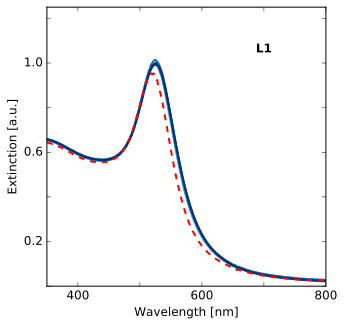

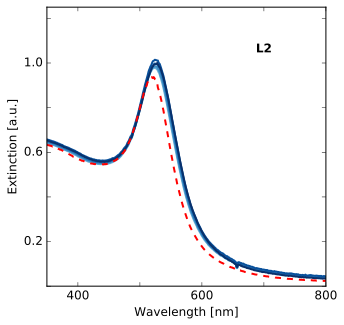

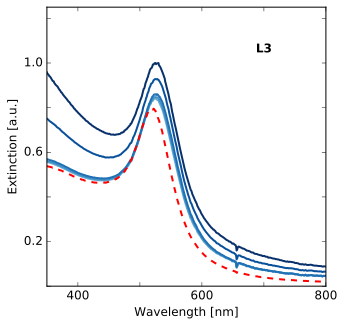

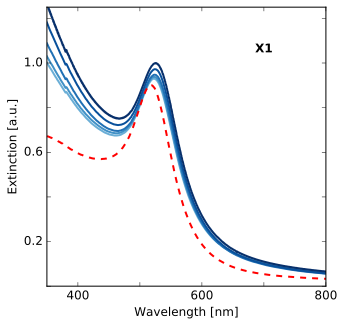

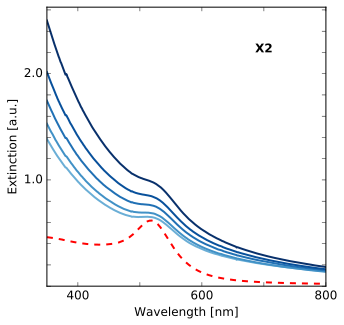

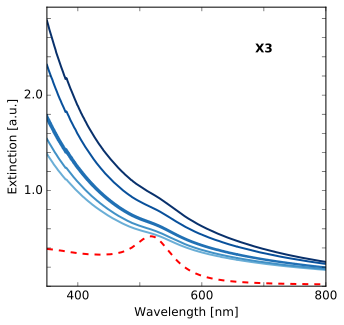

In [100]:
exportFlag = False
pylab.cla()

wlMinnm, wlMaxnm = 350, 800
spectraN = 5
colorList = cm.Blues(np.linspace(0.5, 1, spectraN))
sampleNames = ['L1-thn','L2-med','L3-thk','X1-thn','X2-med','X3-thk']
labelList = ['L1','L2','L3','X1','X2','X3']

for (sampleNum) in range(6):
    spectrumName = sampleNames[sampleNum]
    label = labelList[sampleNum]
    expArray = dataArray[( (dataArray[:,-1] == sampleNum) 
                          & (dataArray[:,0] >= wlMinnm) 
                          & (dataArray[:,0] <= wlMaxnm) )]
    
    xs, ys, colors, lines = [], [], [], []
    
    spectrumCore = spectraCores[0]
    if sampleNum > 2: spectrumCore = spectraCores[1]
    tempList = spectraTemps[sampleNum]
    RhnmList0 = spectraRhnms[sampleNum]
    RhnmList1 = np.unique(expArray[:, 3])
    
    RhnmIdealList = np.linspace(np.mean(np.sort(RhnmList0)[-2:]), np.mean(np.sort(RhnmList0)[:2]), spectraN)
    RhnmList = []
    for Rhnm in RhnmIdealList:
        RhnmList.append(RhnmList1[np.argsort(np.abs(RhnmList1-Rhnm))][0])
    
    # Swelling series
    yNorm = 1
    for spectrumNum in range(spectraN):
        Rhnm = RhnmList[spectrumNum]
        expSubArray = expArray[(expArray[:, -2] == Rhnm)]
        expSubArray = expSubArray[(np.argsort(expSubArray[:, 0]))]
        color = colorList[spectrumNum]
        line = '-'
        x, y = expSubArray[:,0], expSubArray[:,1]
        if (Rhnm == min(RhnmList)): yNorm = max(y[(x > 510)])
        xs.append(x), ys.append(y), colors.append(color), lines.append(line)
    
    # Core reference
    color = 'red'
    line = '--'
    selection = (spectrumCore[:,0] >= wlMin) & (spectrumCore[:,0] <= wlMax)
    plotArray = spectrumCore[selection]
    x, y = plotArray[:,0], plotArray[:,1]
    if (sampleNum < 4): 
        y0 = y[(x == 505)][0]
        yRef0 = ys[0][(xs[0] == 505)][0]
        y = y*yRef0/y0
    else:
        refScale = 0.95*min(ys[0]/y)
        y = y*refScale
    xs.append(x), ys.append(y), colors.append(color), lines.append(line)
    
    ## Plot lines & set limits
    nSets = len(xs)
    for setNum in range(nSets):
        pylab.plot(xs[setNum], ys[setNum]/yNorm, 
                   color=colors[setNum], linestyle=lines[setNum], linewidth=2)
    x, y = [], []
    for setNum in range(nSets):
        for i in range(len(xs[setNum])): 
            x.append(xs[setNum][i]); y.append(ys[setNum][i]/yNorm)
    xLimits = [np.amin(x), np.amax(x)]
    yLimits = [np.amin(y), np.amax(y)]
    dx, dy = abs(xLimits[1]-xLimits[0]), abs(yLimits[1]-yLimits[0])
    
    ## Text and sizing
    ax = pylab.gca()
    ax.set_ylabel("Extinction [a.u.]")
    ax.set_xlabel("Wavelength [nm]")

    xlim = ax.set_xlim([wlMinnm, wlMaxnm])
    xticks = np.arange(400, 850, 100)
    xticklabels = xticks.astype(int).astype(str)
    xticklabels[[1,3]] = '', ''
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    xlim = ax.set_xlim()

    ylim = ax.set_ylim([0,1.25])
    if (sampleNum > 3): ylim = ax.set_ylim([0, 1.05*max(y)])
    yticks = np.arange(ylim[0], ylim[-1], 0.2)
    yticklabels = yticks.astype(str)
    ytickslabeled = [0.2, 0.6, 1.0]
    if (sampleNum > 3): ytickslabeled = [1.0, 2.0]
    for i in range(len(yticks)): 
        if (np.round(yticks[i],1) in np.round(ytickslabeled,1)): yticklabels[i] = '{0:.1f}'.format(yticks[i])
        else: yticklabels[i] = ''
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticklabels)
    ylim = ax.set_ylim() 
    
    xpos = 700
    ypos = ylim[0] + 0.85*(ylim[1]-ylim[0])
    pylab.text(xpos, ypos, label, weight='bold', ha='center', va='center')

    aspect_ratio = 1
    aspect = ( (xlim[1]-xlim[0])/(ylim[1]-ylim[0]) )/aspect_ratio
    ax.set_aspect(aspect)

    ## Save and display
    if (exportFlag):
        fig = pylab.gcf()
        wmmList = [63.5, 85]
        matplotlib.rcParams['svg.fonttype'] = 'none'
        timestamp = ('{:%Y%m%d}'.format(datetime.datetime.now()))
        exportFormat = '.svg'
        identifier = '_spectrum_' + spectrumName
        folder = 'graphics/'
        for wmm in wmmList:
            fig.set_size_inches(wmm/25.4, 1.1*wmm/25.4)
            fontSize = min([int(ceil(wmm/5.7)), 12])
            matplotlib.rcParams.update({'font.size': fontSize})
            for text in fig.texts:
                text.set_fontsize(fontSize)
            sizeName = '_' + str(wmm) + 'mm'
            filename = folder + timestamp + identifier + sizeName + exportFormat
            plt.savefig(filename, transparent=True); print("Exported to:\n", filename)

    plt.show()

    if (exportFlag): 
        matplotlib.rcParams['svg.fonttype'] = 'path'
        matplotlib.rcParams['font.size'] = 12



## SLS curves

Exported to:
 graphics/20170221_sls-X1-thn.svg


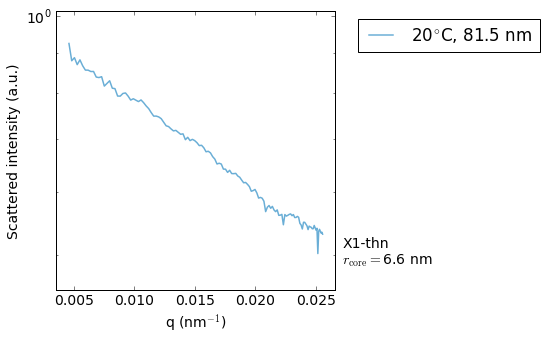

Exported to:
 graphics/20170221_sls-X2-med.svg


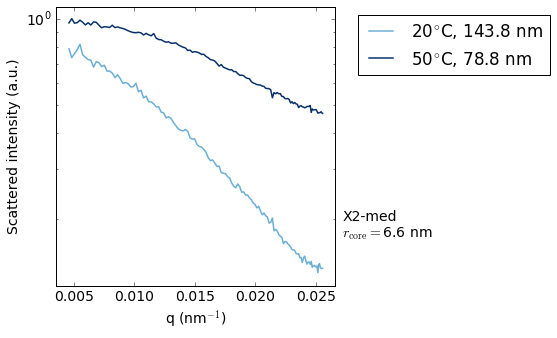

Exported to:
 graphics/20170221_sls-X3-thk.svg


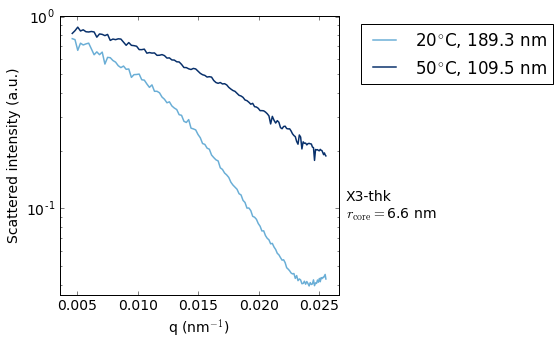

In [13]:
def plotAndSave (shellNum):   
    coreNum = 0
    if shellNum > 2: coreNum = 1
    spectrumNames = ['L1-thn','L2-med','L3-thk','X1-thn','X2-med','X3-thk']
    
    # Experimental data 
    dataArraySwollen = slsIvsqSwollenSample3
    dataArrayCollapsed = slsIvsqRefSample4
    if shellNum == 4: 
        dataArraySwollen = slsIvsqSwollenSample4
        dataArrayCollapsed = slsIvsqRefSample4
    if shellNum == 5: 
        dataArraySwollen = slsIvsqSwollenSample5
        dataArrayCollapsed = slsIvsqRefSample5
    
    # Selection ranges
    rCorenm = coreRnms[coreNum]
    rShellsnm = 0.1*np.round(10*spectraRhnms[shellNum][[1,-1]])

    # initialize lists
    xs, ys, labels = [], [], []
    markers, lines, colors = [], [], []
    nPlots = 3
    #colorList = pylab.cm.hot([0,0.6])
    colorList = pylab.cm.Blues([0.5,1])
    
    # Swollen data set
    if ((shellNum == 3) |(shellNum == 4) | (shellNum == 5)):
        label = '20$^{\circ}$C, ' + str(rShellsnm[0]) + ' nm'
        color = colorList[0]
        line = '-'
        x, y = dataArraySwollen.T
        ddy, dy, y0 = np.polyfit(x[:60], y[:60], 2)
        y = y/y0
        xs.append(x), ys.append(y), labels.append(label)
        lines.append(line)
        colors.append(color)

    # Collapsed data set
    if ((shellNum == 4) | (shellNum == 5)):
        label = '50$^{\circ}$C, ' + str(rShellsnm[1]) + ' nm'
        color = colorList[1]
        marker = ''
        line = '-'
        x, y = dataArrayCollapsed.T
        ddy, dy, y0 = np.polyfit(x[:60], y[:60], 2)
        y = y/y0
        xs.append(x), ys.append(y), labels.append(label)
        lines.append(line)
        colors.append(color)
        
    ## Plot lines & set limits
    nSets = len(xs)
    for setNum in range(nSets):
        pylab.semilogy(xs[setNum], ys[setNum], 
                       label=labels[setNum],
                       color=colors[setNum], 
                       linestyle=lines[setNum], 
                       linewidth=1.5)
    x, y = [], []
    for setNum in range(nSets):
        for i in range(len(xs[setNum])): 
            x.append(xs[setNum][i])
            y.append(ys[setNum][i])
    xLimits = [np.amin(x), np.amax(x)]
    yLimits = [np.amin(y), np.amax(y)]
    dx = abs(xLimits[1]-xLimits[0])
    dy = abs(yLimits[1]-yLimits[0])
    xLimits = [np.amin(x)- 0.05*dx, np.amax(x)+ 0.05*dx]
    yLimits = [0.9*np.amin(y), max([1.01,1.1*np.amax(y)])]
    dx = abs(xLimits[1]-xLimits[0])
    dy = abs(yLimits[1]-yLimits[0])
    
    ## Specific format options
    pylab.xlabel("q (nm$^{-1}$)")
    pylab.ylabel("Scattered intensity (a.u.)")
    figText = ( spectrumNames[shellNum] + '\n'
               + '$r_{\mathrm{core}}=$' 
               + '{0:.1f} nm'.format(rCorenm) 
               )
    pylab.text(xLimits[1]+0.025*dx, yLimits[0]+0.05*dy, 
               figText, fontsize=14, 
               horizontalalignment='left', 
               verticalalignment='bottom')
    pylab.legend(loc='upper left', bbox_to_anchor=(1.05,1))
    
    ## More general format options
    aspectRatio = dx/dy
    figWidthcm = [8.46, 17.78][0] # ACS 1- and 2- column sizes
    figSizein = [figWidthcm/2.54, aspectRatio*figWidthcm/2.54]
    #fig = pylab.figure(1, figsize=(figSizein[0],figSizein[1]))
    #pylab.subplot(111)
    pylab.rcParams.update({'font.size': 14})
    #pylab.axes().set_aspect(aspectRatio)
    pylab.xlim(xLimits[0], xLimits[1])
    pylab.ylim(yLimits[0], yLimits[1])
    pylab.locator_params(axis='x', nbins=7)
    
    ## Save and display
    timestamp = ('{:%Y%m%d}'.format(datetime.datetime.now()))
    exportFormat = '.svg'
    identifier = ("_sls-"
                  + spectrumNames[shellNum]
                  )
    filename = "graphics/" + timestamp + identifier + exportFormat
    pylab.savefig(filename); print("Exported to:\n", filename)
    pylab.show()
    
for shellNum in range(3,6): 
    plotAndSave(shellNum) 

Exported to:
 graphics/20170221_sls-X1-thn_hot-color.svg


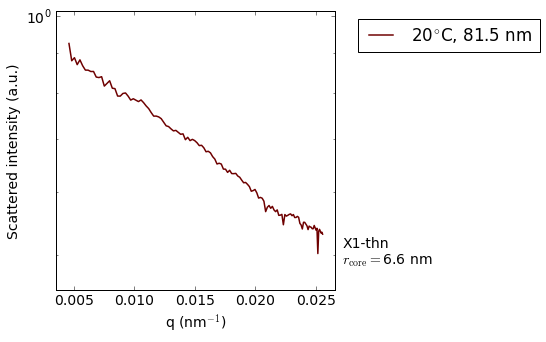

Exported to:
 graphics/20170221_sls-X2-med_hot-color.svg


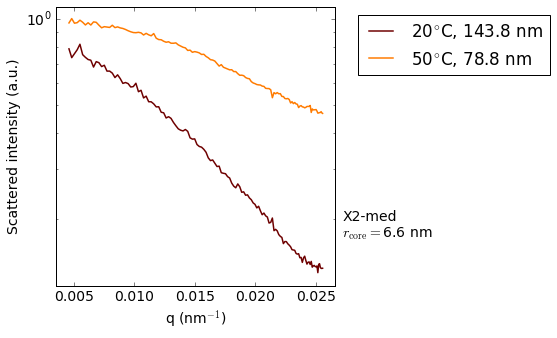

Exported to:
 graphics/20170221_sls-X3-thk_hot-color.svg


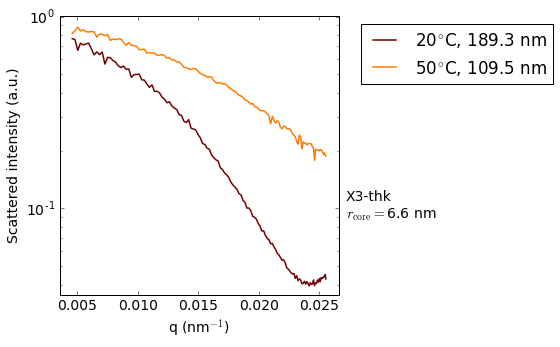

In [14]:
def plotAndSave (shellNum):   
    coreNum = 0
    if shellNum > 2: coreNum = 1
    spectrumNames = ['L1-thn','L2-med','L3-thk','X1-thn','X2-med','X3-thk']
    
    # Experimental data 
    dataArraySwollen = slsIvsqSwollenSample3
    dataArrayCollapsed = slsIvsqRefSample4
    if shellNum == 4: 
        dataArraySwollen = slsIvsqSwollenSample4
        dataArrayCollapsed = slsIvsqRefSample4
    if shellNum == 5: 
        dataArraySwollen = slsIvsqSwollenSample5
        dataArrayCollapsed = slsIvsqRefSample5
    
    # Selection ranges
    rCorenm = coreRnms[coreNum]
    rShellsnm = 0.1*np.round(10*spectraRhnms[shellNum][[1,-1]])

    # initialize lists
    xs, ys, labels = [], [], []
    markers, lines, colors = [], [], []
    colorList = pylab.cm.hot([0.15,0.55])
    #colorList = pylab.cm.Blues([0.3,1])
    
    # Swollen data set
    if ((shellNum == 3) |(shellNum == 4) | (shellNum == 5)):
        label = '20$^{\circ}$C, ' + str(rShellsnm[0]) + ' nm'
        color = colorList[0]
        line = '-'
        x, y = dataArraySwollen.T
        ddy, dy, y0 = np.polyfit(x[:60], y[:60], 2)
        y = y/y0
        xs.append(x), ys.append(y), labels.append(label)
        lines.append(line)
        colors.append(color)

    # Collapsed data set
    if ((shellNum == 4) | (shellNum == 5)):
        label = '50$^{\circ}$C, ' + str(rShellsnm[1]) + ' nm'
        color = colorList[1]
        marker = ''
        line = '-'
        x, y = dataArrayCollapsed.T
        ddy, dy, y0 = np.polyfit(x[:60], y[:60], 2)
        y = y/y0
        xs.append(x), ys.append(y), labels.append(label)
        lines.append(line)
        colors.append(color)
        
    ## Plot lines & set limits
    nSets = len(xs)
    for setNum in range(nSets):
        pylab.semilogy(xs[setNum], ys[setNum], 
                       label=labels[setNum],
                       color=colors[setNum], 
                       linestyle=lines[setNum], 
                       linewidth=1.5)
    x, y = [], []
    for setNum in range(nSets):
        for i in range(len(xs[setNum])): 
            x.append(xs[setNum][i])
            y.append(ys[setNum][i])
    xLimits = [np.amin(x), np.amax(x)]
    yLimits = [np.amin(y), np.amax(y)]
    dx = abs(xLimits[1]-xLimits[0])
    dy = abs(yLimits[1]-yLimits[0])
    xLimits = [np.amin(x)- 0.05*dx, np.amax(x)+ 0.05*dx]
    yLimits = [0.9*np.amin(y), max([1.01,1.1*np.amax(y)])]
    dx = abs(xLimits[1]-xLimits[0])
    dy = abs(yLimits[1]-yLimits[0])
    
    ## Specific format options
    pylab.xlabel("q (nm$^{-1}$)")
    pylab.ylabel("Scattered intensity (a.u.)")
    figText = ( spectrumNames[shellNum] + '\n'
               + '$r_{\mathrm{core}}=$' 
               + '{0:.1f} nm'.format(rCorenm) 
               )
    pylab.text(xLimits[1]+0.025*dx, yLimits[0]+0.05*dy, 
               figText, fontsize=14, 
               horizontalalignment='left', 
               verticalalignment='bottom')
    pylab.legend(loc='upper left', bbox_to_anchor=(1.05,1))
    
    ## More general format options
    aspectRatio = dx/dy
    figWidthcm = [8.46, 17.78][0] # ACS 1- and 2- column sizes
    figSizein = [figWidthcm/2.54, aspectRatio*figWidthcm/2.54]
    #fig = pylab.figure(1, figsize=(figSizein[0],figSizein[1]))
    #pylab.subplot(111)
    pylab.rcParams.update({'font.size': 14})
    #pylab.axes().set_aspect(aspectRatio)
    pylab.xlim(xLimits[0], xLimits[1])
    pylab.ylim(yLimits[0], yLimits[1])
    pylab.locator_params(axis='x', nbins=7)
    
    ## Save and display
    timestamp = ('{:%Y%m%d}'.format(datetime.datetime.now()))
    exportFormat = '.svg'
    identifier = ("_sls-"
                  + spectrumNames[shellNum]
                  +'_hot-color')
    filename = "graphics/" + timestamp + identifier + exportFormat
    pylab.savefig(filename); print("Exported to:\n", filename)
    pylab.show()
    
for shellNum in range(3,6): 
    plotAndSave(shellNum) 

## DLS: Hydrodynamic radius vs temperature

### Seperate graphs

Hydrodynamic radius vs temperature
Exported to:
 graphics/20170222_Rh-vs-T_L1-Thn_.svg


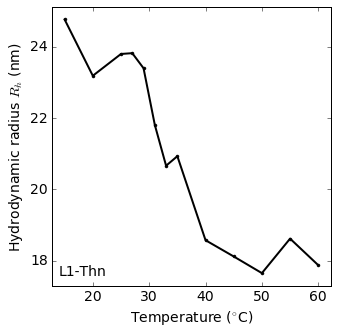

Exported to:
 graphics/20170222_Rh-vs-T_L2-Med_.svg


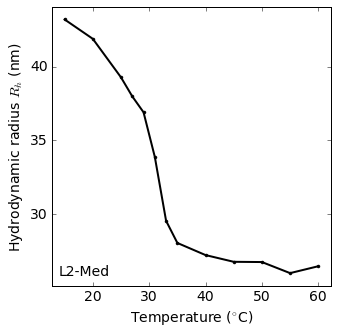

Exported to:
 graphics/20170222_Rh-vs-T_L3-Thk_.svg


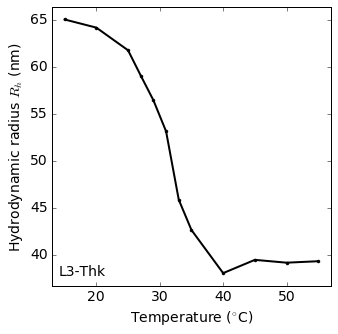

Exported to:
 graphics/20170222_Rh-vs-T_X1-Thn_.svg


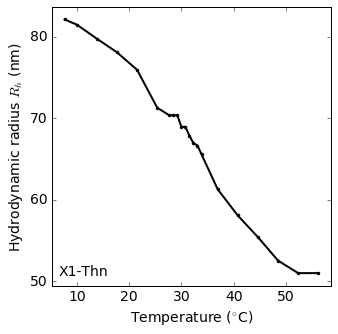

Exported to:
 graphics/20170222_Rh-vs-T_X2-Med_.svg


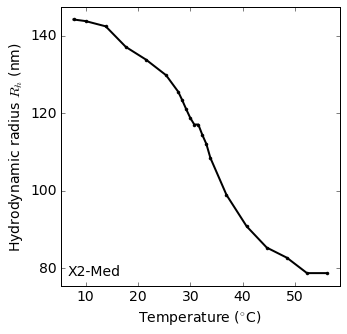

Exported to:
 graphics/20170222_Rh-vs-T_X3-Thk_.svg


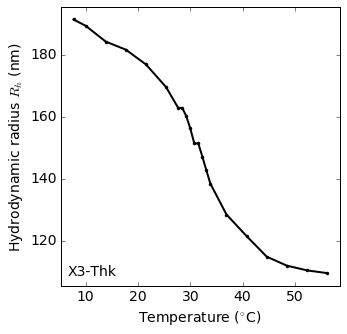

In [15]:
print('Hydrodynamic radius vs temperature')
print('===========')
def plotAndSave (sampleNum):   
    ## Selection ranges    
    spectrumCore = spectraCores[0]
    if sampleNum > 2: spectrumCore = spectraCores[1]
    tempList = spectraTemps[sampleNum]
    RhnmList = spectraRhnms[sampleNum]
    
    # data set 1
    label = 'data'
    color = 'black'
    marker = '.'
    line = ''
    x, y = tempList, RhnmList
    xs, ys = [x], [y]
    labels, colors =  [label], [color]
    markers, lines = [marker], [line]

    # data set 2
    label = 'trace'
    color = 'black'    
    marker = ''
    line = '-'
    select = ((dataArray[:,-1] == sampleNum) 
              & (dataArray[:,0] == dataArray[100,0]))
    plotArray = dataArray[select]
    x, y = plotArray[:,-3], plotArray[:,-2]
    xs.append(x), ys.append(y)
    labels.append(label), colors.append(color)
    markers.append(marker), lines.append(line)
    
    ## Plot lines & set limits
    nSets = len(xs)
    for setNum in range(nSets):
        pylab.plot(xs[setNum], ys[setNum]
                   , label=labels[setNum], color=colors[setNum]
                   , marker=markers[setNum], linestyle=lines[setNum]
                   , linewidth=2)
    x, y = [], []
    for setNum in range(nSets):
        for i in range(len(xs[setNum])): 
            x.append(xs[setNum][i]); y.append(ys[setNum][i])
    xLimits = [np.amin(x), np.amax(x)]
    yLimits = [np.amin(y), np.amax(y)]
    dx, dy = abs(xLimits[1]-xLimits[0]), abs(yLimits[1]-yLimits[0])
    xLimits = [np.amin(x)- 0.05*dx, np.amax(x)+ 0.05*dx]
    yLimits = [np.amin(y)- 0.05*dy, np.amax(y)+ 0.05*dy]
    dx, dy = abs(xLimits[1]-xLimits[0]), abs(yLimits[1]-yLimits[0])
    
    ## Specific format options
    pylab.xlabel("Temperature ($^{\circ}$C)")
    pylab.ylabel("Hydrodynamic radius $R_h$ (nm)")
    figText = (['L1-Thn','L2-Med','L3-Thk','X1-Thn','X2-Med','X3-Thk'][sampleNum])
    pylab.text(xLimits[0]+0.025*dx, yLimits[0]+0.025*dy, figText, verticalalignment='bottom', horizontalalignment='left')
    
    ## More general format options
    pylab.xlim(xLimits[0], xLimits[1])
    pylab.ylim(yLimits[0], yLimits[1])
    pylab.locator_params(nbins=7)
    
    ## Save and display
    timestamp = ('{:%Y%m%d}'.format(datetime.datetime.now()))
    exportFormat = '.svg'
    identifier = ("_Rh-vs-T_"
                 + figText
                 +'_')
    filename = "graphics/" + timestamp + identifier + exportFormat
    pylab.savefig(filename); print("Exported to:\n", filename)
    pylab.show()
    
for sampleNum in range(6): 
    plotAndSave(sampleNum) 


### Plotted together

All samples: peak LSPR wavelength vs hydrodynamic radius
Together without Au cores
Exported to:
 graphics/20170222_Rh-vs-T_all_.svg


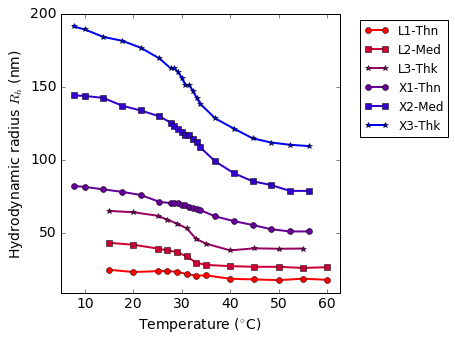

In [16]:
print('All samples: peak LSPR wavelength vs hydrodynamic radius')
print('================================================')
print('Together without Au cores')
def plotAndSave (): 
    pylab.cla()
    
    # data sets
    sampleLabels = []
    xs, ys, labels, colors, markers, lines = [], [], [], [], [], []
    for sampleNum in range(6):
        spectrumCore = spectraCores[0]
        if sampleNum > 2: spectrumCore = spectraCores[1]
        tempList = spectraTemps[sampleNum]
        RhnmList = spectraRhnms[sampleNum]
        label = (['L1-Thn','L2-Med','L3-Thk','X1-Thn','X2-Med','X3-Thk'][sampleNum])
        color = (['#ff0000','#cc0035','#990066','#660099','#3300cc','#0000ff'][sampleNum])
        marker = (['o','s','*','o','s','*'][sampleNum])
        line = '-'
        x, y = tempList, RhnmList
        xs.append(x), ys.append(y), labels.append(label), 
        colors.append(color), markers.append(marker), lines.append(line)
        sampleLabels.append(label)
    
    ## Plot lines & set limits
    nSets = len(xs)
    for setNum in range(nSets):
        pylab.plot(xs[setNum], ys[setNum]
                   , label=labels[setNum], color=colors[setNum]
                   , linestyle=lines[setNum], marker=markers[setNum]
                   , linewidth=2)
    x, y = [], []
    for setNum in range(nSets):
        for i in range(len(xs[setNum])): 
            x.append(xs[setNum][i]); y.append(ys[setNum][i])
    xLimits = [np.amin(x), np.amax(x)]
    yLimits = [np.amin(y), np.amax(y)]
    dx, dy = abs(xLimits[1]-xLimits[0]), abs(yLimits[1]-yLimits[0])
    xLimits = [np.amin(x)- 0.05*dx, np.amax(x)+ 0.05*dx]
    yLimits = [np.amin(y)- 0.05*dy, np.amax(y)+ 0.05*dy]
    dx, dy = abs(xLimits[1]-xLimits[0]), abs(yLimits[1]-yLimits[0])
    
    ## Specific format options
    pylab.ylabel('Hydrodynamic radius $R_h$ (nm)')
    pylab.xlabel("Temperature ($^{\circ}$C)")
    pylab.legend(loc='upper left', bbox_to_anchor=(1.05, 1), fontsize=12)
    
    ## More general format options
    pylab.xlim(xLimits[0], xLimits[1])
    pylab.ylim(yLimits[0], yLimits[1])
    pylab.locator_params(nbins=7)
    
    ## Save and display
    timestamp = ('{:%Y%m%d}'.format(datetime.datetime.now()))
    exportFormat = '.svg'
    identifier = ("_Rh-vs-T_all_" )
    filename = "graphics/" + timestamp + identifier + exportFormat
    pylab.savefig(filename); print("Exported to:\n", filename)
    pylab.show()
    
plotAndSave()

### Plotted separately with common axes scales

All samples: hydrodynamic radius
Together without Au cores
Exported to:
 graphics/20170222_Rh-vs-T_common-axes_L1-Thn.svg


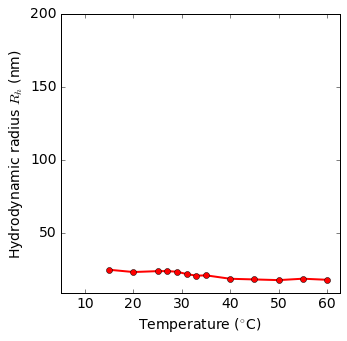

Exported to:
 graphics/20170222_Rh-vs-T_common-axes_L2-Med.svg


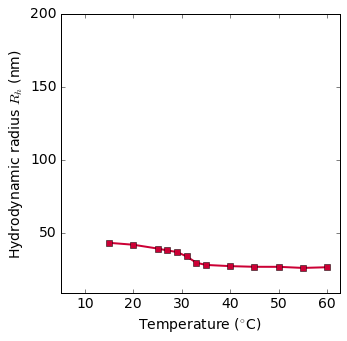

Exported to:
 graphics/20170222_Rh-vs-T_common-axes_L3-Thk.svg


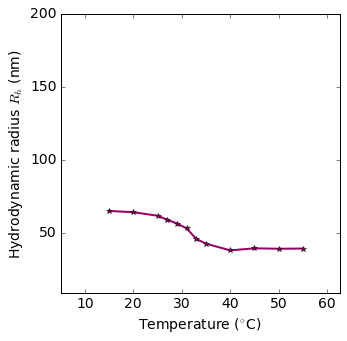

Exported to:
 graphics/20170222_Rh-vs-T_common-axes_X1-Thn.svg


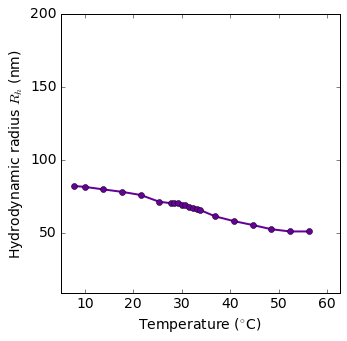

Exported to:
 graphics/20170222_Rh-vs-T_common-axes_X2-Med.svg


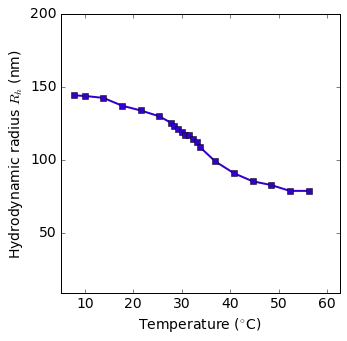

Exported to:
 graphics/20170222_Rh-vs-T_common-axes_X3-Thk.svg


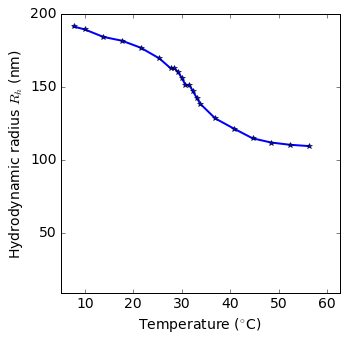

In [17]:
print('All samples: hydrodynamic radius')
print('================================================')
print('Together without Au cores')
def plotAndSave (plotNum): 
    pylab.cla()
    
    # data sets
    sampleLabels = []
    xs, ys, labels, colors, markers, lines = [], [], [], [], [], []
    for sampleNum in range(6):
        spectrumCore = spectraCores[0]
        if sampleNum > 2: spectrumCore = spectraCores[1]
        tempList = spectraTemps[sampleNum]
        RhnmList = spectraRhnms[sampleNum]
        label = (['L1-Thn','L2-Med','L3-Thk','X1-Thn','X2-Med','X3-Thk'][sampleNum])
        color = (['#ff0000','#cc0035','#990066','#660099','#3300cc','#0000ff'][sampleNum])
        marker = (['o','s','*','o','s','*'][sampleNum])
        line = '-'
        x, y = tempList, RhnmList
        xs.append(x), ys.append(y), labels.append(label), 
        colors.append(color), markers.append(marker), lines.append(line)
        sampleLabels.append(label)
    
    ## Plot lines & set limits
    nSets = len(xs)
    for setNum in [plotNum]:
        pylab.plot(xs[setNum], ys[setNum]
                   , label=labels[setNum], color=colors[setNum]
                   , linestyle=lines[setNum], marker=markers[setNum]
                   , linewidth=2)
    x, y = [], []
    for setNum in range(nSets):
        for i in range(len(xs[setNum])): 
            x.append(xs[setNum][i]); y.append(ys[setNum][i])
    xLimits = [np.amin(x), np.amax(x)]
    yLimits = [np.amin(y), np.amax(y)]
    dx, dy = abs(xLimits[1]-xLimits[0]), abs(yLimits[1]-yLimits[0])
    xLimits = [np.amin(x)- 0.05*dx, np.amax(x)+ 0.05*dx]
    yLimits = [np.amin(y)- 0.05*dy, np.amax(y)+ 0.05*dy]
    dx, dy = abs(xLimits[1]-xLimits[0]), abs(yLimits[1]-yLimits[0])
    
    ## Specific format options
    pylab.ylabel('Hydrodynamic radius $R_h$ (nm)')
    pylab.xlabel("Temperature ($^{\circ}$C)")
    
    ## More general format options
    pylab.xlim(xLimits[0], xLimits[1])
    pylab.ylim(yLimits[0], yLimits[1])
    pylab.locator_params(nbins=7)
    
    ## Save and display
    timestamp = ('{:%Y%m%d}'.format(datetime.datetime.now()))
    exportFormat = '.svg'
    identifier = ("_Rh-vs-T_common-axes_" + labels[plotNum])
    filename = "graphics/" + timestamp + identifier + exportFormat
    pylab.savefig(filename); print("Exported to:\n", filename)
    pylab.show()
    
for plotNum in range(6): plotAndSave(plotNum)

### Plotted together, log plot

All samples: peak LSPR wavelength vs hydrodynamic radius
Together without Au cores
Exported to:
 graphics/20170222_Rh-vs-T_log_all.svg


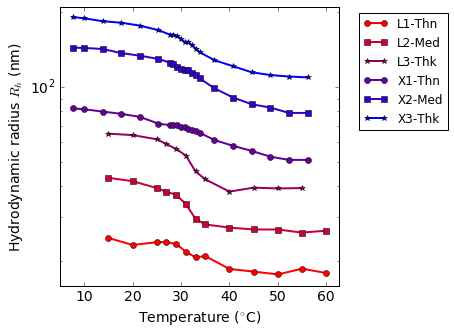

In [19]:
print('All samples: peak LSPR wavelength vs hydrodynamic radius')
print('================================================')
print('Together without Au cores')
def plotAndSave (): 
    pylab.cla()
    
    # data sets
    nPlots = 6
    sampleLabels = []
    colorList = pylab.cm.hot(np.linspace(0.75,0.0,nPlots))
    xs, ys, labels, colors, markers, lines = [], [], [], [], [], []
    for sampleNum in range(nPlots):
        spectrumCore = spectraCores[0]
        if sampleNum > 2: spectrumCore = spectraCores[1]
        tempList = spectraTemps[sampleNum]
        RhnmList = spectraRhnms[sampleNum]
        label = (['L1-Thn','L2-Med','L3-Thk','X1-Thn','X2-Med','X3-Thk'][sampleNum])
        color = (['#ff0000','#cc0035','#990066','#660099','#3300cc','#0000ff'][sampleNum])
        marker = (['o','s','*','o','s','*'][sampleNum])
        line = '-'
        x, y = tempList, RhnmList
        xs.append(x), ys.append(y), labels.append(label), 
        colors.append(color), markers.append(marker), lines.append(line)
        sampleLabels.append(label)
    
    ## Plot lines & set limits
    nSets = len(xs)
    for setNum in range(nSets):
        pylab.semilogy(xs[setNum], ys[setNum]
                       , label=labels[setNum], color=colors[setNum]
                       , linestyle=lines[setNum], marker=markers[setNum]
                       , linewidth=2)
    x, y = [], []
    for setNum in range(nSets):
        for i in range(len(xs[setNum])): 
            x.append(xs[setNum][i]); y.append(ys[setNum][i])
    xLimits = [np.amin(x), np.amax(x)]
    yLimits = [np.amin(y), np.amax(y)]
    dx, dy = abs(xLimits[1]-xLimits[0]), abs(yLimits[1]-yLimits[0])
    xLimits = [np.amin(x)- 0.05*dx, np.amax(x)+ 0.05*dx]
    yLimits = [0.9*np.amin(y), 1.1*np.amax(y)]
    dx, dy = abs(xLimits[1]-xLimits[0]), abs(yLimits[1]-yLimits[0])
    
    ## Specific format options
    pylab.ylabel('Hydrodynamic radius $R_h$ (nm)')
    pylab.xlabel("Temperature ($^{\circ}$C)")
    pylab.legend(loc='upper left', bbox_to_anchor=(1.05, 1), fontsize=12)
    
    ## More general format options
    pylab.xlim(xLimits[0], xLimits[1])
    pylab.ylim(yLimits[0], yLimits[1])
    pylab.locator_params(axis='x', nbins=7)
    
    ## Save and display
    timestamp = ('{:%Y%m%d}'.format(datetime.datetime.now()))
    exportFormat = '.svg'
    identifier = ("_Rh-vs-T_log_all" )
    filename = "graphics/" + timestamp + identifier + exportFormat
    pylab.savefig(filename); print("Exported to:\n", filename)
    pylab.show()
    
plotAndSave()

### Plotted separately with common axes, log plot

All samples: peak LSPR wavelength vs hydrodynamic radius
Together without Au cores
Exported to:
 graphics/20170222_Rh-vs-T_log_all_L1-Thn.svg


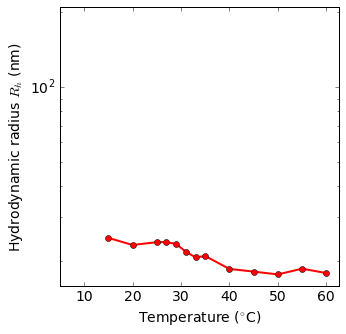

Exported to:
 graphics/20170222_Rh-vs-T_log_all_L2-Med.svg


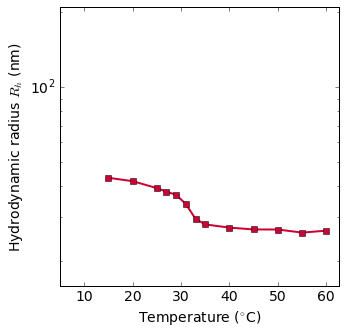

Exported to:
 graphics/20170222_Rh-vs-T_log_all_L3-Thk.svg


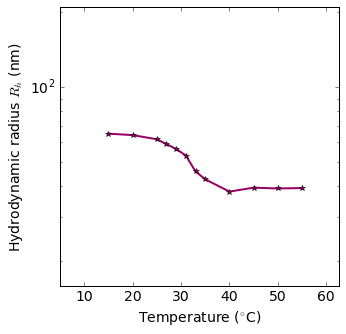

Exported to:
 graphics/20170222_Rh-vs-T_log_all_X1-Thn.svg


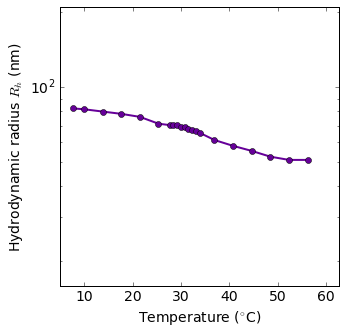

Exported to:
 graphics/20170222_Rh-vs-T_log_all_X2-Med.svg


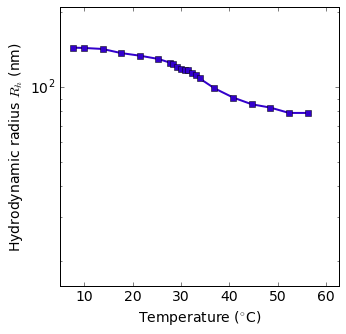

Exported to:
 graphics/20170222_Rh-vs-T_log_all_X3-Thk.svg


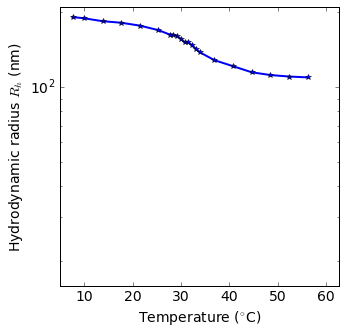

In [21]:
print('All samples: peak LSPR wavelength vs hydrodynamic radius')
print('================================================')
print('Together without Au cores')
def plotAndSave (plotNum): 
    pylab.cla()
    
    # data sets
    sampleLabels = []
    xs, ys, labels, colors, markers, lines = [], [], [], [], [], []
    nPlots = len(spectraTemps)
    for sampleNum in range(nPlots):
        spectrumCore = spectraCores[0]
        if sampleNum > 2: spectrumCore = spectraCores[1]
        tempList = spectraTemps[sampleNum]
        RhnmList = spectraRhnms[sampleNum]
        label = (['L1-Thn','L2-Med','L3-Thk','X1-Thn','X2-Med','X3-Thk'][sampleNum])
        color = (['#ff0000','#cc0035','#990066','#660099','#3300cc','#0000ff'][sampleNum])
        marker = (['o','s','*','o','s','*'][sampleNum])
        line = '-'
        x, y = tempList, RhnmList
        xs.append(x), ys.append(y), labels.append(label), 
        colors.append(color), markers.append(marker), lines.append(line)
        sampleLabels.append(label)
    
    ## Plot lines & set limits
    nSets = len(xs)
    for setNum in [plotNum]:
        pylab.semilogy(xs[setNum], ys[setNum]
                       , label=labels[setNum], color=colors[setNum]
                       , linestyle=lines[setNum], marker=markers[setNum]
                       , linewidth=2)
    x, y = [], []
    for setNum in range(nSets):
        for i in range(len(xs[setNum])): 
            x.append(xs[setNum][i]); y.append(ys[setNum][i])
    xLimits = [np.amin(x), np.amax(x)]
    yLimits = [np.amin(y), np.amax(y)]
    dx, dy = abs(xLimits[1]-xLimits[0]), abs(yLimits[1]-yLimits[0])
    xLimits = [np.amin(x)- 0.05*dx, np.amax(x)+ 0.05*dx]
    yLimits = [0.9*np.amin(y), 1.1*np.amax(y)]
    dx, dy = abs(xLimits[1]-xLimits[0]), abs(yLimits[1]-yLimits[0])
    
    ## Specific format options
    pylab.ylabel('Hydrodynamic radius $R_h$ (nm)')
    pylab.xlabel("Temperature ($^{\circ}$C)")
    
    ## More general format options
    pylab.xlim(xLimits[0], xLimits[1])
    pylab.ylim(yLimits[0], yLimits[1])
    pylab.locator_params(axis='x', nbins=7)
    
    ## Save and display
    timestamp = ('{:%Y%m%d}'.format(datetime.datetime.now()))
    exportFormat = '.svg'
    identifier = ("_Rh-vs-T_log_all_" + labels[plotNum])
    filename = "graphics/" + timestamp + identifier + exportFormat
    pylab.savefig(filename); print("Exported to:\n", filename)
    pylab.show()
    
for plotNum in range(6): plotAndSave(plotNum)

## DLS: Shell volume swelling ratio vs temperature

### Seperate graphs

Hydrodynamic radius vs temperature
Exported to:
 graphics/20170222_Vol-ratio-vs-T_L1-Thn_.svg


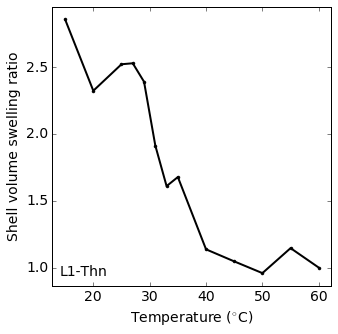

Exported to:
 graphics/20170222_Vol-ratio-vs-T_L2-Med_.svg


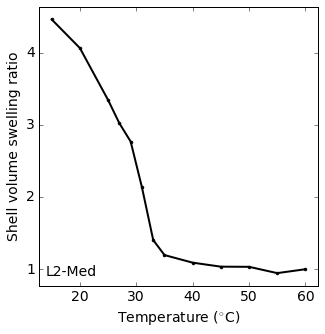

Exported to:
 graphics/20170222_Vol-ratio-vs-T_L3-Thk_.svg


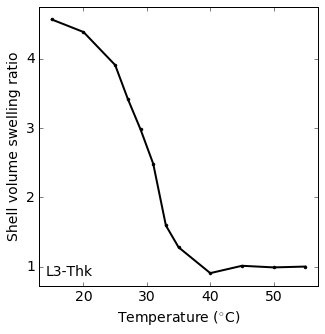

Exported to:
 graphics/20170222_Vol-ratio-vs-T_X1-Thn_.svg


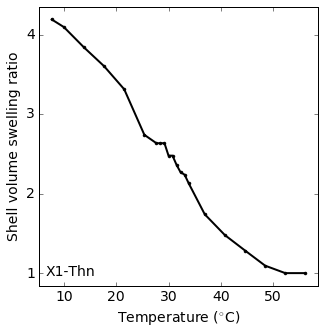

Exported to:
 graphics/20170222_Vol-ratio-vs-T_X2-Med_.svg


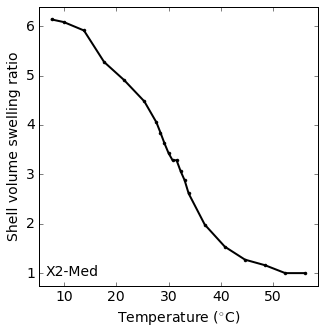

Exported to:
 graphics/20170222_Vol-ratio-vs-T_X3-Thk_.svg


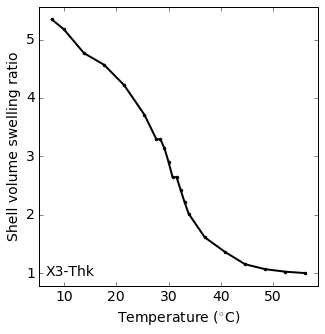

In [32]:
print('Hydrodynamic radius vs temperature')
print('===========')
def plotAndSave (sampleNum):   
    ## Selection ranges    
    spectrumCore = spectraCores[0]
    if sampleNum > 2: spectrumCore = spectraCores[1]
    rCorenm = coreRnms[0]
    if sampleNum > 2: rCorenm = coreRnms[1]
    tempList = spectraTemps[sampleNum]
    RhnmList = spectraRhnms[sampleNum]
    
    # data set 1
    label = 'data'
    color = 'black'
    marker = '.'
    line = ''
    x, y = tempList, RhnmList
    y = (y**3 - rCorenm**3)/(y[-1]**3 - rCorenm**3)
    xs, ys = [x], [y]
    labels, colors =  [label], [color]
    markers, lines = [marker], [line]

    # data set 2
    label = 'trace'
    color = 'black'    
    marker = ''
    line = '-'
    select = ((dataArray[:,-1] == sampleNum) 
              & (dataArray[:,0] == dataArray[100,0]))
    plotArray = dataArray[select]
    x, y = plotArray[:,-3], plotArray[:,-2]
    y = (y**3 - rCorenm**3)/(y[-1]**3 - rCorenm**3)
    xs.append(x), ys.append(y)
    labels.append(label), colors.append(color)
    markers.append(marker), lines.append(line)
    
    ## Plot lines & set limits
    nSets = len(xs)
    for setNum in range(nSets):
        pylab.plot(xs[setNum], ys[setNum]
                   , label=labels[setNum], color=colors[setNum]
                   , marker=markers[setNum], linestyle=lines[setNum]
                   , linewidth=2)
    x, y = [], []
    for setNum in range(nSets):
        for i in range(len(xs[setNum])): 
            x.append(xs[setNum][i]); y.append(ys[setNum][i])
    xLimits = [np.amin(x), np.amax(x)]
    yLimits = [np.amin(y), np.amax(y)]
    dx, dy = abs(xLimits[1]-xLimits[0]), abs(yLimits[1]-yLimits[0])
    xLimits = [np.amin(x)- 0.05*dx, np.amax(x)+ 0.05*dx]
    yLimits = [np.amin(y)- 0.05*dy, np.amax(y)+ 0.05*dy]
    dx, dy = abs(xLimits[1]-xLimits[0]), abs(yLimits[1]-yLimits[0])
    
    ## Specific format options
    pylab.xlabel("Temperature ($^{\circ}$C)")
    pylab.ylabel("Shell volume swelling ratio")
    figText = (['L1-Thn','L2-Med','L3-Thk','X1-Thn','X2-Med','X3-Thk'][sampleNum])
    pylab.text(xLimits[0]+0.025*dx, yLimits[0]+0.025*dy, figText, verticalalignment='bottom', horizontalalignment='left')
    
    ## More general format options
    pylab.xlim(xLimits[0], xLimits[1])
    pylab.ylim(yLimits[0], yLimits[1])
    pylab.locator_params(nbins=7)
    
    ## Save and display
    timestamp = ('{:%Y%m%d}'.format(datetime.datetime.now()))
    exportFormat = '.svg'
    identifier = ("_Vol-ratio-vs-T_"
                 + figText
                 +'_')
    filename = "graphics/" + timestamp + identifier + exportFormat
    pylab.savefig(filename); print("Exported to:\n", filename)
    pylab.show()
    
for sampleNum in range(6): 
    plotAndSave(sampleNum) 


### Plotted together

Exported to:
 graphics/20170222_Vol-ratio-vs-T_all_.svg


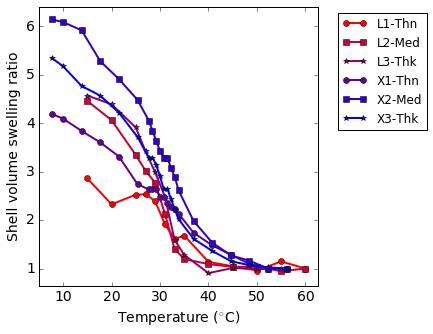

In [33]:
def plotAndSave (): 
    pylab.cla()
    
    # data sets
    sampleLabels = []
    xs, ys, labels, colors, markers, lines = [], [], [], [], [], []
    for sampleNum in range(6):
        spectrumCore = spectraCores[0]
        if sampleNum > 2: spectrumCore = spectraCores[1]
        rCorenm = coreRnms[0]
        if sampleNum > 2: rCorenm = coreRnms[1]
        tempList = spectraTemps[sampleNum]
        RhnmList = spectraRhnms[sampleNum]
        label = (['L1-Thn','L2-Med','L3-Thk','X1-Thn','X2-Med','X3-Thk'][sampleNum])
        color = (['#ff0000','#cc0035','#990066','#660099','#3300cc','#0000ff'][sampleNum])
        marker = (['o','s','*','o','s','*'][sampleNum])
        line = '-'
        x, y = tempList, RhnmList
        y = (y**3 - rCorenm**3)/(y[-1]**3 - rCorenm**3)
        xs.append(x), ys.append(y), labels.append(label), 
        colors.append(color), markers.append(marker), lines.append(line)
        sampleLabels.append(label)
    
    ## Plot lines & set limits
    nSets = len(xs)
    for setNum in range(nSets):
        pylab.plot(xs[setNum], ys[setNum]
                   , label=labels[setNum], color=colors[setNum]
                   , linestyle=lines[setNum], marker=markers[setNum]
                   , linewidth=2)
    x, y = [], []
    for setNum in range(nSets):
        for i in range(len(xs[setNum])): 
            x.append(xs[setNum][i]); y.append(ys[setNum][i])
    xLimits = [np.amin(x), np.amax(x)]
    yLimits = [np.amin(y), np.amax(y)]
    dx, dy = abs(xLimits[1]-xLimits[0]), abs(yLimits[1]-yLimits[0])
    xLimits = [np.amin(x)- 0.05*dx, np.amax(x)+ 0.05*dx]
    yLimits = [np.amin(y)- 0.05*dy, np.amax(y)+ 0.05*dy]
    dx, dy = abs(xLimits[1]-xLimits[0]), abs(yLimits[1]-yLimits[0])
    
    ## Specific format options
    pylab.ylabel("Shell volume swelling ratio")
    pylab.xlabel("Temperature ($^{\circ}$C)")
    pylab.legend(loc='upper left', bbox_to_anchor=(1.05, 1), fontsize=12)
    
    ## More general format options
    pylab.xlim(xLimits[0], xLimits[1])
    pylab.ylim(yLimits[0], yLimits[1])
    pylab.locator_params(nbins=7)
    
    ## Save and display
    timestamp = ('{:%Y%m%d}'.format(datetime.datetime.now()))
    exportFormat = '.svg'
    identifier = ("_Vol-ratio-vs-T_all_" )
    filename = "graphics/" + timestamp + identifier + exportFormat
    pylab.savefig(filename); print("Exported to:\n", filename)
    pylab.show()
    
plotAndSave()

### Plotted separately with common axes scales

All samples: hydrodynamic radius
Together without Au cores
Exported to:
 graphics/20170222_Vol-ratio-vs-T_common-axes_L1-Thn.svg


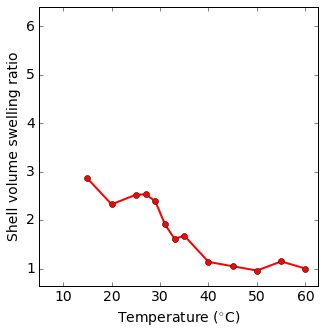

Exported to:
 graphics/20170222_Vol-ratio-vs-T_common-axes_L2-Med.svg


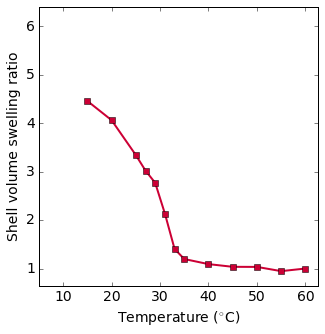

Exported to:
 graphics/20170222_Vol-ratio-vs-T_common-axes_L3-Thk.svg


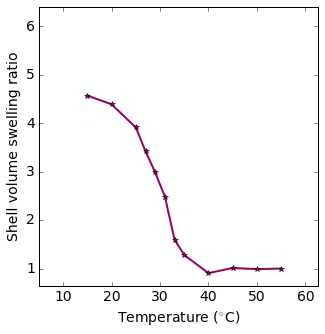

Exported to:
 graphics/20170222_Vol-ratio-vs-T_common-axes_X1-Thn.svg


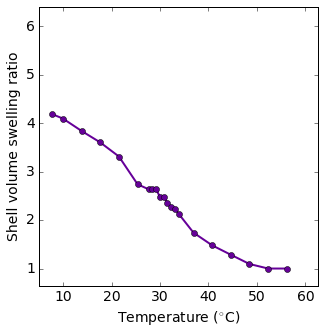

Exported to:
 graphics/20170222_Vol-ratio-vs-T_common-axes_X2-Med.svg


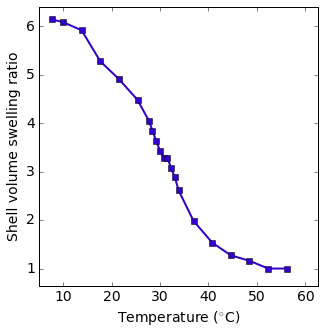

Exported to:
 graphics/20170222_Vol-ratio-vs-T_common-axes_X3-Thk.svg


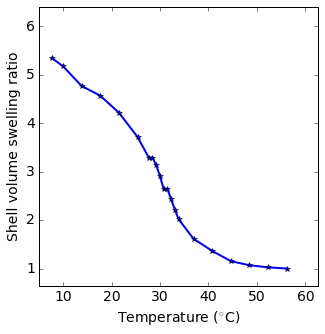

In [34]:
print('All samples: hydrodynamic radius')
print('================================================')
print('Together without Au cores')
def plotAndSave (plotNum): 
    pylab.cla()
    
    # data sets
    sampleLabels = []
    xs, ys, labels, colors, markers, lines = [], [], [], [], [], []
    for sampleNum in range(6):
        spectrumCore = spectraCores[0]
        if sampleNum > 2: spectrumCore = spectraCores[1]
        rCorenm = coreRnms[0]
        if sampleNum > 2: rCorenm = coreRnms[1]
        tempList = spectraTemps[sampleNum]
        RhnmList = spectraRhnms[sampleNum]
        label = (['L1-Thn','L2-Med','L3-Thk','X1-Thn','X2-Med','X3-Thk'][sampleNum])
        color = (['#ff0000','#cc0035','#990066','#660099','#3300cc','#0000ff'][sampleNum])
        marker = (['o','s','*','o','s','*'][sampleNum])
        line = '-'
        x, y = tempList, RhnmList
        y = (y**3 - rCorenm**3)/(y[-1]**3 - rCorenm**3)
        xs.append(x), ys.append(y), labels.append(label), 
        colors.append(color), markers.append(marker), lines.append(line)
        sampleLabels.append(label)
    
    ## Plot lines & set limits
    nSets = len(xs)
    for setNum in [plotNum]:
        pylab.plot(xs[setNum], ys[setNum]
                   , label=labels[setNum], color=colors[setNum]
                   , linestyle=lines[setNum], marker=markers[setNum]
                   , linewidth=2)
    x, y = [], []
    for setNum in range(nSets):
        for i in range(len(xs[setNum])): 
            x.append(xs[setNum][i]); y.append(ys[setNum][i])
    xLimits = [np.amin(x), np.amax(x)]
    yLimits = [np.amin(y), np.amax(y)]
    dx, dy = abs(xLimits[1]-xLimits[0]), abs(yLimits[1]-yLimits[0])
    xLimits = [np.amin(x)- 0.05*dx, np.amax(x)+ 0.05*dx]
    yLimits = [np.amin(y)- 0.05*dy, np.amax(y)+ 0.05*dy]
    dx, dy = abs(xLimits[1]-xLimits[0]), abs(yLimits[1]-yLimits[0])
    
    ## Specific format options
    pylab.ylabel("Shell volume swelling ratio")
    pylab.xlabel("Temperature ($^{\circ}$C)")
    
    ## More general format options
    pylab.xlim(xLimits[0], xLimits[1])
    pylab.ylim(yLimits[0], yLimits[1])
    pylab.locator_params(nbins=7)
    
    ## Save and display
    timestamp = ('{:%Y%m%d}'.format(datetime.datetime.now()))
    exportFormat = '.svg'
    identifier = ("_Vol-ratio-vs-T_common-axes_" + labels[plotNum])
    filename = "graphics/" + timestamp + identifier + exportFormat
    pylab.savefig(filename); print("Exported to:\n", filename)
    pylab.show()
    
for plotNum in range(6): plotAndSave(plotNum)

### Plotted together, log plot

All samples: peak LSPR wavelength vs hydrodynamic radius
Together without Au cores
Exported to:
 graphics/20170222_Vol-ratio-vs-T_log_all.svg


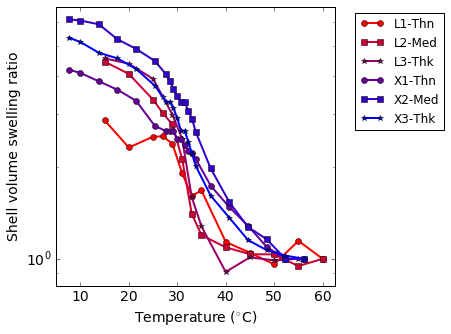

In [35]:
print('All samples: peak LSPR wavelength vs hydrodynamic radius')
print('================================================')
print('Together without Au cores')
def plotAndSave (): 
    pylab.cla()
    
    # data sets
    nPlots = 6
    sampleLabels = []
    colorList = pylab.cm.hot(np.linspace(0.75,0.0,nPlots))
    xs, ys, labels, colors, markers, lines = [], [], [], [], [], []
    for sampleNum in range(nPlots):
        spectrumCore = spectraCores[0]
        if sampleNum > 2: spectrumCore = spectraCores[1]
        rCorenm = coreRnms[0]
        if sampleNum > 2: rCorenm = coreRnms[1]
        tempList = spectraTemps[sampleNum]
        RhnmList = spectraRhnms[sampleNum]
        label = (['L1-Thn','L2-Med','L3-Thk','X1-Thn','X2-Med','X3-Thk'][sampleNum])
        color = (['#ff0000','#cc0035','#990066','#660099','#3300cc','#0000ff'][sampleNum])
        marker = (['o','s','*','o','s','*'][sampleNum])
        line = '-'
        x, y = tempList, RhnmList
        y = (y**3 - rCorenm**3)/(y[-1]**3 - rCorenm**3)
        xs.append(x), ys.append(y), labels.append(label), 
        colors.append(color), markers.append(marker), lines.append(line)
        sampleLabels.append(label)
    
    ## Plot lines & set limits
    nSets = len(xs)
    for setNum in range(nSets):
        pylab.semilogy(xs[setNum], ys[setNum]
                       , label=labels[setNum], color=colors[setNum]
                       , linestyle=lines[setNum], marker=markers[setNum]
                       , linewidth=2)
    x, y = [], []
    for setNum in range(nSets):
        for i in range(len(xs[setNum])): 
            x.append(xs[setNum][i]); y.append(ys[setNum][i])
    xLimits = [np.amin(x), np.amax(x)]
    yLimits = [np.amin(y), np.amax(y)]
    dx, dy = abs(xLimits[1]-xLimits[0]), abs(yLimits[1]-yLimits[0])
    xLimits = [np.amin(x)- 0.05*dx, np.amax(x)+ 0.05*dx]
    yLimits = [0.9*np.amin(y), 1.1*np.amax(y)]
    dx, dy = abs(xLimits[1]-xLimits[0]), abs(yLimits[1]-yLimits[0])
    
    ## Specific format options
    pylab.ylabel("Shell volume swelling ratio")
    pylab.xlabel("Temperature ($^{\circ}$C)")
    pylab.legend(loc='upper left', bbox_to_anchor=(1.05, 1), fontsize=12)
    
    ## More general format options
    pylab.xlim(xLimits[0], xLimits[1])
    pylab.ylim(yLimits[0], yLimits[1])
    pylab.locator_params(axis='x', nbins=7)
    
    ## Save and display
    timestamp = ('{:%Y%m%d}'.format(datetime.datetime.now()))
    exportFormat = '.svg'
    identifier = ("_Vol-ratio-vs-T_log_all" )
    filename = "graphics/" + timestamp + identifier + exportFormat
    pylab.savefig(filename); print("Exported to:\n", filename)
    pylab.show()
    
plotAndSave()

### Plotted separately with common axes, log plot

Exported to:
 graphics/20170222_Vol-ratio-vs-T_log_all_L1-Thn.svg


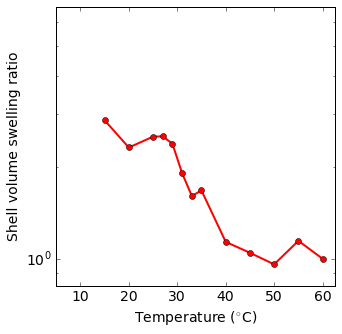

Exported to:
 graphics/20170222_Vol-ratio-vs-T_log_all_L2-Med.svg


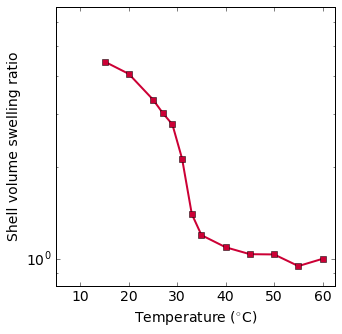

Exported to:
 graphics/20170222_Vol-ratio-vs-T_log_all_L3-Thk.svg


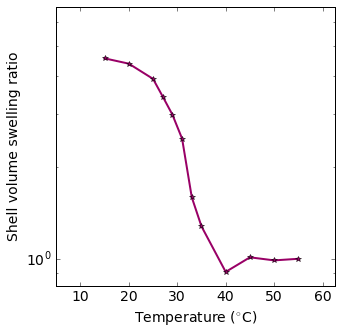

Exported to:
 graphics/20170222_Vol-ratio-vs-T_log_all_X1-Thn.svg


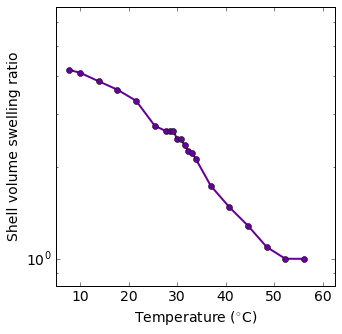

Exported to:
 graphics/20170222_Vol-ratio-vs-T_log_all_X2-Med.svg


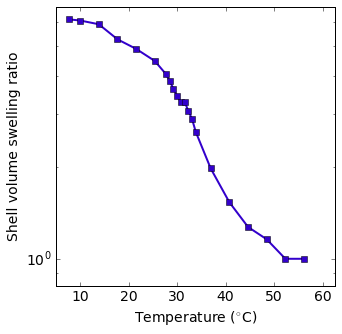

Exported to:
 graphics/20170222_Vol-ratio-vs-T_log_all_X3-Thk.svg


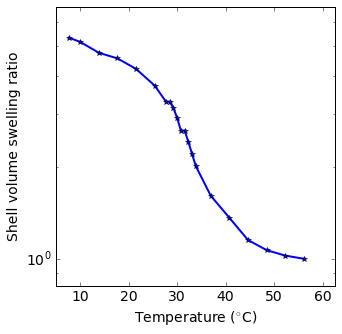

In [36]:
def plotAndSave (plotNum): 
    pylab.cla()
    
    # data sets
    sampleLabels = []
    xs, ys, labels, colors, markers, lines = [], [], [], [], [], []
    nPlots = len(spectraTemps)
    for sampleNum in range(nPlots):
        spectrumCore = spectraCores[0]
        if sampleNum > 2: spectrumCore = spectraCores[1]
        rCorenm = coreRnms[0]
        if sampleNum > 2: rCorenm = coreRnms[1]
        tempList = spectraTemps[sampleNum]
        RhnmList = spectraRhnms[sampleNum]
        label = (['L1-Thn','L2-Med','L3-Thk','X1-Thn','X2-Med','X3-Thk'][sampleNum])
        color = (['#ff0000','#cc0035','#990066','#660099','#3300cc','#0000ff'][sampleNum])
        marker = (['o','s','*','o','s','*'][sampleNum])
        line = '-'
        x, y = tempList, RhnmList
        y = (y**3 - rCorenm**3)/(y[-1]**3 - rCorenm**3)
        xs.append(x), ys.append(y), labels.append(label), 
        colors.append(color), markers.append(marker), lines.append(line)
        sampleLabels.append(label)
    
    ## Plot lines & set limits
    nSets = len(xs)
    for setNum in [plotNum]:
        pylab.semilogy(xs[setNum], ys[setNum]
                       , label=labels[setNum], color=colors[setNum]
                       , linestyle=lines[setNum], marker=markers[setNum]
                       , linewidth=2)
    x, y = [], []
    for setNum in range(nSets):
        for i in range(len(xs[setNum])): 
            x.append(xs[setNum][i]); y.append(ys[setNum][i])
    xLimits = [np.amin(x), np.amax(x)]
    yLimits = [np.amin(y), np.amax(y)]
    dx, dy = abs(xLimits[1]-xLimits[0]), abs(yLimits[1]-yLimits[0])
    xLimits = [np.amin(x)- 0.05*dx, np.amax(x)+ 0.05*dx]
    yLimits = [0.9*np.amin(y), 1.1*np.amax(y)]
    dx, dy = abs(xLimits[1]-xLimits[0]), abs(yLimits[1]-yLimits[0])
    
    ## Specific format options
    pylab.ylabel("Shell volume swelling ratio")
    pylab.xlabel("Temperature ($^{\circ}$C)")
    
    ## More general format options
    pylab.xlim(xLimits[0], xLimits[1])
    pylab.ylim(yLimits[0], yLimits[1])
    pylab.locator_params(axis='x', nbins=7)
    
    ## Save and display
    timestamp = ('{:%Y%m%d}'.format(datetime.datetime.now()))
    exportFormat = '.svg'
    identifier = ("_Vol-ratio-vs-T_log_all_" + labels[plotNum])
    filename = "graphics/" + timestamp + identifier + exportFormat
    pylab.savefig(filename); print("Exported to:\n", filename)
    pylab.show()
    
for plotNum in range(6): plotAndSave(plotNum)

## DLS: Shell-to-core ratio vs temperature

### Seperate graphs

Exported to:
 graphics/20170222_Rad-ratio-vs-T_L1-Thn_.svg


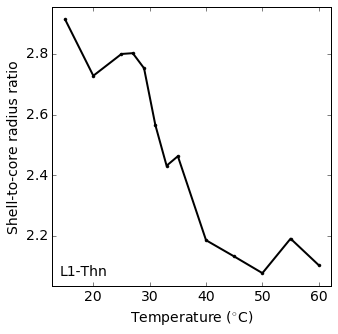

Exported to:
 graphics/20170222_Rad-ratio-vs-T_L2-Med_.svg


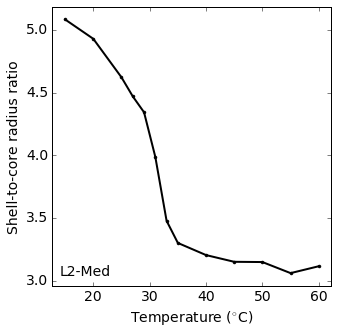

Exported to:
 graphics/20170222_Rad-ratio-vs-T_L3-Thk_.svg


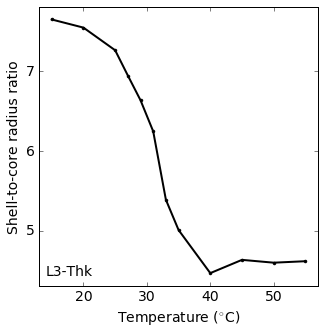

Exported to:
 graphics/20170222_Rad-ratio-vs-T_X1-Thn_.svg


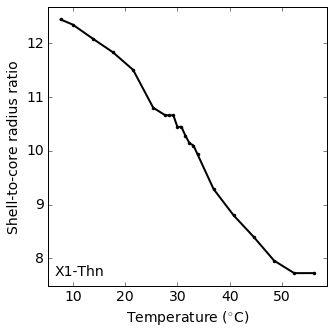

Exported to:
 graphics/20170222_Rad-ratio-vs-T_X2-Med_.svg


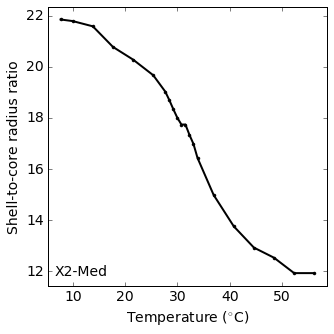

Exported to:
 graphics/20170222_Rad-ratio-vs-T_X3-Thk_.svg


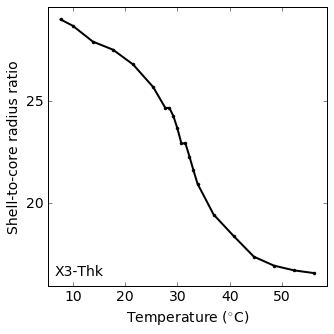

In [42]:
def plotAndSave (sampleNum):   
    ## Selection ranges    
    spectrumCore = spectraCores[0]
    if sampleNum > 2: spectrumCore = spectraCores[1]
    rCorenm = coreRnms[0]
    if sampleNum > 2: rCorenm = coreRnms[1]
    tempList = spectraTemps[sampleNum]
    RhnmList = spectraRhnms[sampleNum]
    
    # data set 1
    label = 'data'
    color = 'black'
    marker = '.'
    line = ''
    x, y = tempList, RhnmList
    y = y/rCorenm
    xs, ys = [x], [y]
    labels, colors =  [label], [color]
    markers, lines = [marker], [line]

    # data set 2
    label = 'trace'
    color = 'black'    
    marker = ''
    line = '-'
    select = ((dataArray[:,-1] == sampleNum) 
              & (dataArray[:,0] == dataArray[100,0]))
    plotArray = dataArray[select]
    x, y = plotArray[:,-3], plotArray[:,-2]
    y = (y/rCorenm)
    xs.append(x), ys.append(y)
    labels.append(label), colors.append(color)
    markers.append(marker), lines.append(line)
    
    ## Plot lines & set limits
    nSets = len(xs)
    for setNum in range(nSets):
        pylab.plot(xs[setNum], ys[setNum]
                   , label=labels[setNum], color=colors[setNum]
                   , marker=markers[setNum], linestyle=lines[setNum]
                   , linewidth=2)
    x, y = [], []
    for setNum in range(nSets):
        for i in range(len(xs[setNum])): 
            x.append(xs[setNum][i]); y.append(ys[setNum][i])
    xLimits = [np.amin(x), np.amax(x)]
    yLimits = [np.amin(y), np.amax(y)]
    dx, dy = abs(xLimits[1]-xLimits[0]), abs(yLimits[1]-yLimits[0])
    xLimits = [np.amin(x)- 0.05*dx, np.amax(x)+ 0.05*dx]
    yLimits = [np.amin(y)- 0.05*dy, np.amax(y)+ 0.05*dy]
    dx, dy = abs(xLimits[1]-xLimits[0]), abs(yLimits[1]-yLimits[0])
    
    ## Specific format options
    pylab.xlabel("Temperature ($^{\circ}$C)")
    pylab.ylabel("Shell-to-core radius ratio")
    figText = (['L1-Thn','L2-Med','L3-Thk','X1-Thn','X2-Med','X3-Thk'][sampleNum])
    pylab.text(xLimits[0]+0.025*dx, yLimits[0]+0.025*dy, figText, verticalalignment='bottom', horizontalalignment='left')
    
    ## More general format options
    pylab.xlim(xLimits[0], xLimits[1])
    pylab.ylim(yLimits[0], yLimits[1])
    pylab.locator_params(nbins=7)
    
    ## Save and display
    timestamp = ('{:%Y%m%d}'.format(datetime.datetime.now()))
    exportFormat = '.svg'
    identifier = ("_Rad-ratio-vs-T_"
                 + figText
                 +'_')
    filename = "graphics/" + timestamp + identifier + exportFormat
    pylab.savefig(filename); print("Exported to:\n", filename)
    pylab.show()
    
for sampleNum in range(6): 
    plotAndSave(sampleNum) 


### Plotted together

Exported to:
 graphics/20170222_Rad-ratio-vs-T_all_.svg


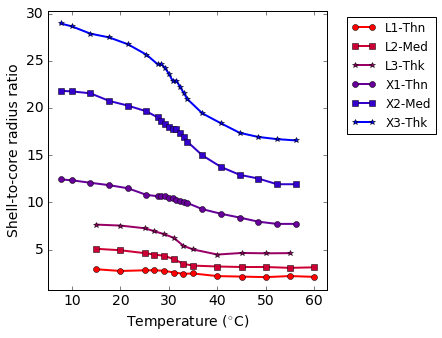

In [43]:
def plotAndSave (): 
    pylab.cla()
    
    # data sets
    sampleLabels = []
    xs, ys, labels, colors, markers, lines = [], [], [], [], [], []
    for sampleNum in range(6):
        spectrumCore = spectraCores[0]
        if sampleNum > 2: spectrumCore = spectraCores[1]
        rCorenm = coreRnms[0]
        if sampleNum > 2: rCorenm = coreRnms[1]
        tempList = spectraTemps[sampleNum]
        RhnmList = spectraRhnms[sampleNum]
        label = (['L1-Thn','L2-Med','L3-Thk','X1-Thn','X2-Med','X3-Thk'][sampleNum])
        color = (['#ff0000','#cc0035','#990066','#660099','#3300cc','#0000ff'][sampleNum])
        marker = (['o','s','*','o','s','*'][sampleNum])
        line = '-'
        x, y = tempList, RhnmList
        y = (y/rCorenm)
        xs.append(x), ys.append(y), labels.append(label), 
        colors.append(color), markers.append(marker), lines.append(line)
        sampleLabels.append(label)
    
    ## Plot lines & set limits
    nSets = len(xs)
    for setNum in range(nSets):
        pylab.plot(xs[setNum], ys[setNum]
                   , label=labels[setNum], color=colors[setNum]
                   , linestyle=lines[setNum], marker=markers[setNum]
                   , linewidth=2)
    x, y = [], []
    for setNum in range(nSets):
        for i in range(len(xs[setNum])): 
            x.append(xs[setNum][i]); y.append(ys[setNum][i])
    xLimits = [np.amin(x), np.amax(x)]
    yLimits = [np.amin(y), np.amax(y)]
    dx, dy = abs(xLimits[1]-xLimits[0]), abs(yLimits[1]-yLimits[0])
    xLimits = [np.amin(x)- 0.05*dx, np.amax(x)+ 0.05*dx]
    yLimits = [np.amin(y)- 0.05*dy, np.amax(y)+ 0.05*dy]
    dx, dy = abs(xLimits[1]-xLimits[0]), abs(yLimits[1]-yLimits[0])
    
    ## Specific format options
    pylab.ylabel("Shell-to-core radius ratio")
    pylab.xlabel("Temperature ($^{\circ}$C)")
    pylab.legend(loc='upper left', bbox_to_anchor=(1.05, 1), fontsize=12)
    
    ## More general format options
    pylab.xlim(xLimits[0], xLimits[1])
    pylab.ylim(yLimits[0], yLimits[1])
    pylab.locator_params(nbins=7)
    
    ## Save and display
    timestamp = ('{:%Y%m%d}'.format(datetime.datetime.now()))
    exportFormat = '.svg'
    identifier = ("_Rad-ratio-vs-T_all_" )
    filename = "graphics/" + timestamp + identifier + exportFormat
    pylab.savefig(filename); print("Exported to:\n", filename)
    pylab.show()
    
plotAndSave()

### Plotted separately with common axes scales

All samples: hydrodynamic radius
Together without Au cores
Exported to:
 graphics/20170222_Rad-ratio-vs-T_common-axes_L1-Thn.svg


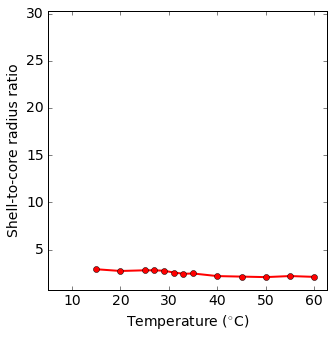

Exported to:
 graphics/20170222_Rad-ratio-vs-T_common-axes_L2-Med.svg


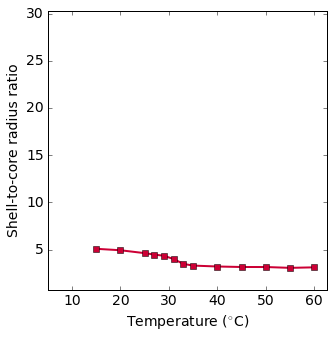

Exported to:
 graphics/20170222_Rad-ratio-vs-T_common-axes_L3-Thk.svg


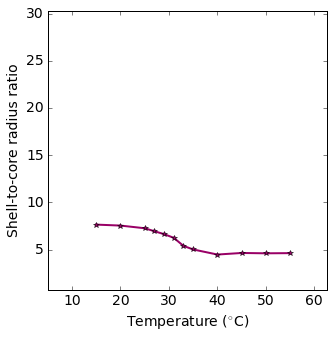

Exported to:
 graphics/20170222_Rad-ratio-vs-T_common-axes_X1-Thn.svg


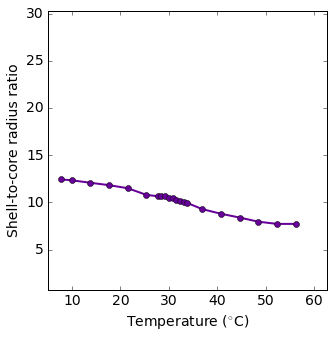

Exported to:
 graphics/20170222_Rad-ratio-vs-T_common-axes_X2-Med.svg


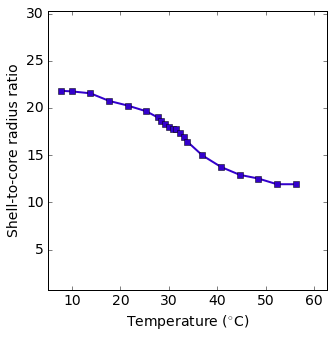

Exported to:
 graphics/20170222_Rad-ratio-vs-T_common-axes_X3-Thk.svg


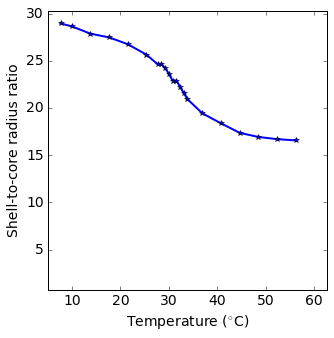

In [44]:
print('All samples: hydrodynamic radius')
print('================================================')
print('Together without Au cores')
def plotAndSave (plotNum): 
    pylab.cla()
    
    # data sets
    sampleLabels = []
    xs, ys, labels, colors, markers, lines = [], [], [], [], [], []
    for sampleNum in range(6):
        spectrumCore = spectraCores[0]
        if sampleNum > 2: spectrumCore = spectraCores[1]
        rCorenm = coreRnms[0]
        if sampleNum > 2: rCorenm = coreRnms[1]
        tempList = spectraTemps[sampleNum]
        RhnmList = spectraRhnms[sampleNum]
        label = (['L1-Thn','L2-Med','L3-Thk','X1-Thn','X2-Med','X3-Thk'][sampleNum])
        color = (['#ff0000','#cc0035','#990066','#660099','#3300cc','#0000ff'][sampleNum])
        marker = (['o','s','*','o','s','*'][sampleNum])
        line = '-'
        x, y = tempList, RhnmList
        y = (y/rCorenm)
        xs.append(x), ys.append(y), labels.append(label), 
        colors.append(color), markers.append(marker), lines.append(line)
        sampleLabels.append(label)
    
    ## Plot lines & set limits
    nSets = len(xs)
    for setNum in [plotNum]:
        pylab.plot(xs[setNum], ys[setNum]
                   , label=labels[setNum], color=colors[setNum]
                   , linestyle=lines[setNum], marker=markers[setNum]
                   , linewidth=2)
    x, y = [], []
    for setNum in range(nSets):
        for i in range(len(xs[setNum])): 
            x.append(xs[setNum][i]); y.append(ys[setNum][i])
    xLimits = [np.amin(x), np.amax(x)]
    yLimits = [np.amin(y), np.amax(y)]
    dx, dy = abs(xLimits[1]-xLimits[0]), abs(yLimits[1]-yLimits[0])
    xLimits = [np.amin(x)- 0.05*dx, np.amax(x)+ 0.05*dx]
    yLimits = [np.amin(y)- 0.05*dy, np.amax(y)+ 0.05*dy]
    dx, dy = abs(xLimits[1]-xLimits[0]), abs(yLimits[1]-yLimits[0])
    
    ## Specific format options
    pylab.ylabel("Shell-to-core radius ratio")
    pylab.xlabel("Temperature ($^{\circ}$C)")
    
    ## More general format options
    pylab.xlim(xLimits[0], xLimits[1])
    pylab.ylim(yLimits[0], yLimits[1])
    pylab.locator_params(nbins=7)
    
    ## Save and display
    timestamp = ('{:%Y%m%d}'.format(datetime.datetime.now()))
    exportFormat = '.svg'
    identifier = ("_Rad-ratio-vs-T_common-axes_" + labels[plotNum])
    filename = "graphics/" + timestamp + identifier + exportFormat
    pylab.savefig(filename); print("Exported to:\n", filename)
    pylab.show()
    
for plotNum in range(6): plotAndSave(plotNum)

### Plotted together, log plot

All samples: peak LSPR wavelength vs hydrodynamic radius
Together without Au cores
Exported to:
 graphics/20170222_Rad-ratio-vs-T_log_all.svg


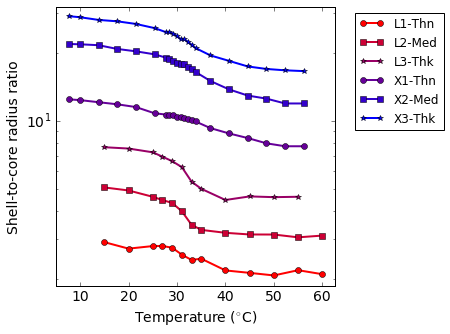

In [45]:
print('All samples: peak LSPR wavelength vs hydrodynamic radius')
print('================================================')
print('Together without Au cores')
def plotAndSave (): 
    pylab.cla()
    
    # data sets
    nPlots = 6
    sampleLabels = []
    colorList = pylab.cm.hot(np.linspace(0.75,0.0,nPlots))
    xs, ys, labels, colors, markers, lines = [], [], [], [], [], []
    for sampleNum in range(nPlots):
        spectrumCore = spectraCores[0]
        if sampleNum > 2: spectrumCore = spectraCores[1]
        rCorenm = coreRnms[0]
        if sampleNum > 2: rCorenm = coreRnms[1]
        tempList = spectraTemps[sampleNum]
        RhnmList = spectraRhnms[sampleNum]
        label = (['L1-Thn','L2-Med','L3-Thk','X1-Thn','X2-Med','X3-Thk'][sampleNum])
        color = (['#ff0000','#cc0035','#990066','#660099','#3300cc','#0000ff'][sampleNum])
        marker = (['o','s','*','o','s','*'][sampleNum])
        line = '-'
        x, y = tempList, RhnmList
        y = (y/rCorenm)
        xs.append(x), ys.append(y), labels.append(label), 
        colors.append(color), markers.append(marker), lines.append(line)
        sampleLabels.append(label)
    
    ## Plot lines & set limits
    nSets = len(xs)
    for setNum in range(nSets):
        pylab.semilogy(xs[setNum], ys[setNum]
                       , label=labels[setNum], color=colors[setNum]
                       , linestyle=lines[setNum], marker=markers[setNum]
                       , linewidth=2)
    x, y = [], []
    for setNum in range(nSets):
        for i in range(len(xs[setNum])): 
            x.append(xs[setNum][i]); y.append(ys[setNum][i])
    xLimits = [np.amin(x), np.amax(x)]
    yLimits = [np.amin(y), np.amax(y)]
    dx, dy = abs(xLimits[1]-xLimits[0]), abs(yLimits[1]-yLimits[0])
    xLimits = [np.amin(x)- 0.05*dx, np.amax(x)+ 0.05*dx]
    yLimits = [0.9*np.amin(y), 1.1*np.amax(y)]
    dx, dy = abs(xLimits[1]-xLimits[0]), abs(yLimits[1]-yLimits[0])
    
    ## Specific format options
    pylab.ylabel("Shell-to-core radius ratio")
    pylab.xlabel("Temperature ($^{\circ}$C)")
    pylab.legend(loc='upper left', bbox_to_anchor=(1.05, 1), fontsize=12)
    
    ## More general format options
    pylab.xlim(xLimits[0], xLimits[1])
    pylab.ylim(yLimits[0], yLimits[1])
    pylab.locator_params(axis='x', nbins=7)
    
    ## Save and display
    timestamp = ('{:%Y%m%d}'.format(datetime.datetime.now()))
    exportFormat = '.svg'
    identifier = ("_Rad-ratio-vs-T_log_all" )
    filename = "graphics/" + timestamp + identifier + exportFormat
    pylab.savefig(filename); print("Exported to:\n", filename)
    pylab.show()
    
plotAndSave()

### Plotted separately with common axes, log plot

Exported to:
 graphics/20170222_Rad-ratio-vs-T_log_all_L1-Thn.svg


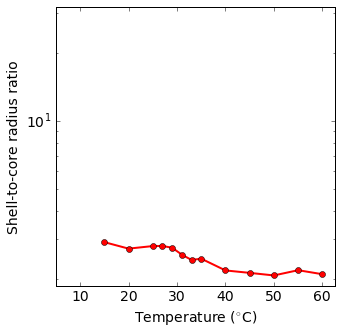

Exported to:
 graphics/20170222_Rad-ratio-vs-T_log_all_L2-Med.svg


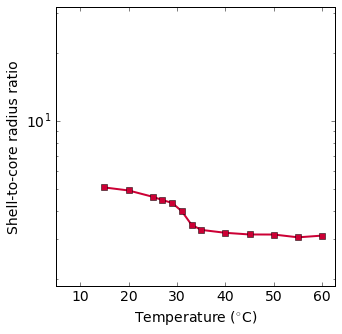

Exported to:
 graphics/20170222_Rad-ratio-vs-T_log_all_L3-Thk.svg


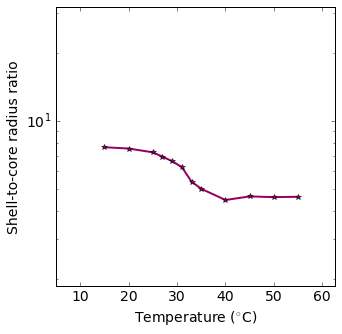

Exported to:
 graphics/20170222_Rad-ratio-vs-T_log_all_X1-Thn.svg


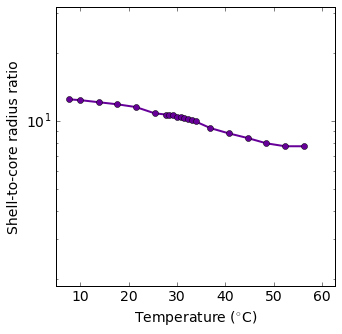

Exported to:
 graphics/20170222_Rad-ratio-vs-T_log_all_X2-Med.svg


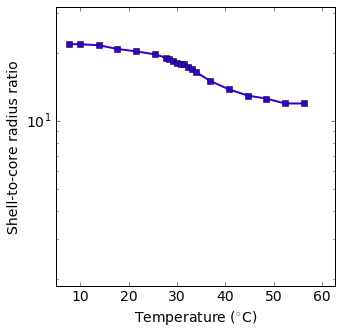

Exported to:
 graphics/20170222_Rad-ratio-vs-T_log_all_X3-Thk.svg


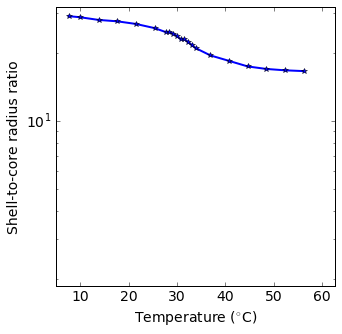

In [46]:
def plotAndSave (plotNum): 
    pylab.cla()
    
    # data sets
    sampleLabels = []
    xs, ys, labels, colors, markers, lines = [], [], [], [], [], []
    nPlots = len(spectraTemps)
    for sampleNum in range(nPlots):
        spectrumCore = spectraCores[0]
        if sampleNum > 2: spectrumCore = spectraCores[1]
        rCorenm = coreRnms[0]
        if sampleNum > 2: rCorenm = coreRnms[1]
        tempList = spectraTemps[sampleNum]
        RhnmList = spectraRhnms[sampleNum]
        label = (['L1-Thn','L2-Med','L3-Thk','X1-Thn','X2-Med','X3-Thk'][sampleNum])
        color = (['#ff0000','#cc0035','#990066','#660099','#3300cc','#0000ff'][sampleNum])
        marker = (['o','s','*','o','s','*'][sampleNum])
        line = '-'
        x, y = tempList, RhnmList
        y = (y/rCorenm)
        xs.append(x), ys.append(y), labels.append(label), 
        colors.append(color), markers.append(marker), lines.append(line)
        sampleLabels.append(label)
    
    ## Plot lines & set limits
    nSets = len(xs)
    for setNum in [plotNum]:
        pylab.semilogy(xs[setNum], ys[setNum]
                       , label=labels[setNum], color=colors[setNum]
                       , linestyle=lines[setNum], marker=markers[setNum]
                       , linewidth=2)
    x, y = [], []
    for setNum in range(nSets):
        for i in range(len(xs[setNum])): 
            x.append(xs[setNum][i]); y.append(ys[setNum][i])
    xLimits = [np.amin(x), np.amax(x)]
    yLimits = [np.amin(y), np.amax(y)]
    dx, dy = abs(xLimits[1]-xLimits[0]), abs(yLimits[1]-yLimits[0])
    xLimits = [np.amin(x)- 0.05*dx, np.amax(x)+ 0.05*dx]
    yLimits = [0.9*np.amin(y), 1.1*np.amax(y)]
    dx, dy = abs(xLimits[1]-xLimits[0]), abs(yLimits[1]-yLimits[0])
    
    ## Specific format options
    pylab.ylabel("Shell-to-core radius ratio")
    pylab.xlabel("Temperature ($^{\circ}$C)")
    
    ## More general format options
    pylab.xlim(xLimits[0], xLimits[1])
    pylab.ylim(yLimits[0], yLimits[1])
    pylab.locator_params(axis='x', nbins=7)
    
    ## Save and display
    timestamp = ('{:%Y%m%d}'.format(datetime.datetime.now()))
    exportFormat = '.svg'
    identifier = ("_Rad-ratio-vs-T_log_all_" + labels[plotNum])
    filename = "graphics/" + timestamp + identifier + exportFormat
    pylab.savefig(filename); print("Exported to:\n", filename)
    pylab.show()
    
for plotNum in range(6): plotAndSave(plotNum)

# Formatted graphs

## Shell-to-core ratio (Rh/Rcore) vs temperature, log scale, with range bars

Exported to:
 graphics/20170320_Rh-ratio-vs-Temp_Range-bars_85mm.svg
Exported to:
 graphics/20170320_Rh-ratio-vs-Temp_Range-bars_92.5mm.svg


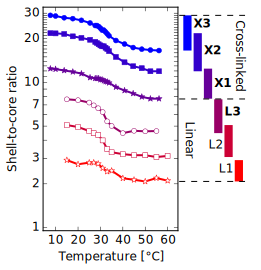

In [34]:
exportFlag = True

colorList = ['#ff0000','#cc0035','#990066','#660099','#3300cc','#0000ff']
labelList = ['L1','L2','L3','X1','X2','X3']

# data sets
sampleLabels = []
xs, ys, labels, colors, markers, lines = [], [], [], [], [], []
bary0s, bardys = [], []
for sampleNum in range(6):
    spectrumCore = spectraCores[0]
    if sampleNum > 2: spectrumCore = spectraCores[1]
    rCorenm = coreRnms[0]
    if sampleNum > 2: rCorenm = coreRnms[1]
    tempList = spectraTemps[sampleNum]
    RhnmList = spectraRhnms[sampleNum]
    label = (labelList[sampleNum])
    color = (colorList[sampleNum])
    marker = (['*','s','o','*','s','o'][sampleNum])
    line = '-'
    x, y = tempList, RhnmList
    y = np.log((y/rCorenm))
    
    xs.append(x), ys.append(y), labels.append(label), 
    colors.append(color), markers.append(marker), lines.append(line)
    sampleLabels.append(label)
    
    bary0 = min(y)
    bardy = np.abs(max(y)-min(y)).tolist()
    bary0s.append(bary0), bardys.append(bardy)
    
## Construct figure
width, width2 = 52.302, 26.508
height = 90
fig, (ax, ax2) = plt.subplots(1, 2, sharey=True, 
                              gridspec_kw={'width_ratios':[width/width2, 1]})

## Plot lines 
nSets = len(xs)
for setNum in range(nSets):
    fc, ms = 'white', 5
    if setNum > 2: fc = colors[setNum]
    if setNum in [0,3]: ms = 6.5
    ax.plot(xs[setNum], ys[setNum]
                   , label=labels[setNum], color=colors[setNum]
                   , linestyle=lines[setNum], marker=markers[setNum]
                   , markeredgewidth=0.5, markeredgecolor=colors[setNum]
                   , markerfacecolor=fc, markersize=ms
                   , linewidth=2)

## Text and sizing
ax.set_ylabel("Shell-to-core ratio")
ax.set_xlabel("Temperature [°C]")

xlim = ax.set_xlim([5.5, 63.5])
xticks = np.arange(10, 61, 10)
xticklabels = xticks.astype(int).astype(str)
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)
xlim = ax.set_xlim()

ylim = ax.set_ylim(np.log([0.95,33]))
yticks = np.arange(1, 31, 1)
yticklabels = (yticks.astype(int)).astype(str)
ytickslabeled = [1, 2, 3, 5, 7, 10, 20, 30]
for i in range(len(yticks)): 
    if (yticks[i] not in ytickslabeled): yticklabels[i] = ''
yticks = np.log(yticks)
ax.set_yticks(yticks)
ax.set_yticklabels(yticklabels)
ylim = ax.set_ylim() 

width, height = 50.5, 90
aspect_ratio = width/height
aspect = ( (xlim[1]-xlim[0])/(ylim[1]-ylim[0]) )/aspect_ratio
ax.set_aspect(aspect)

## Range bars
bardx, barDx = (1/nSets)*(4/5), (1/nSets)*(1/5)
for setNum in range(nSets):
    posx = (nSets-1-setNum)*(bardx+barDx)
    posy = bary0s[setNum]
    dx, dy = bardx, bardys[setNum]
    ax2.add_patch(matplotlib.patches.Rectangle(
            (posx, posy), dx, dy,
            facecolor=colors[setNum], 
            edgecolor='none'
    ))
    
    if (setNum < 2):
        posx = (nSets-1-(setNum+1))*(bardx+barDx) + bardx
        posy = 0.5*(bary0s[setNum] + bary0s[setNum+1])
        if (setNum == 2): posy = bary0s[setNum] + 0.5*bardys[setNum]
        ax2.text(posx, posy, labels[setNum], ha='right', va='center')
    else:
        posx = (nSets-1-(setNum-1))*(bardx+barDx)
        posy = 0.5*(bary0s[setNum] + bardys[setNum] + bary0s[setNum-1] + bardys[setNum-1])
        if (setNum == 3): posy = bary0s[setNum] + 0.5*bardys[setNum]
        ax2.text(posx, posy, labels[setNum], ha='left', va='center', weight='bold')


xlim2 = ax2.set_xlim([-2*barDx,1])
ylim2 = ax2.set_ylim(ylim) 
y0 = bary0s[0]
ax2.plot(xlim2, [y0, y0], '--', color='black')
y1 = 0.5*(bary0s[2]+bardys[2] + bary0s[3])
ax2.plot(xlim2, [y1, y1], '--', color='black')
y2 = bary0s[-1]+bardys[-1]
ax2.plot(xlim2, [y2, y2], '--', color='black')

ax2.text(1, 0.5*(y1+y2), 'Cross-linked', rotation=270, ha='right', va='center')
ax2.text(0, 0.5*(y0+y1), 'Linear', rotation=270, ha='left', va='center')

aspect_ratio = width2/height
aspect = ( (xlim2[1]-xlim2[0])/(ylim2[1]-ylim2[0]) )/aspect_ratio
ax2.set_aspect(aspect)
ax2.axis('off')

plt.subplots_adjust(wspace=0, hspace=0)

## Save and display
if (exportFlag):
    wmmList = [85, 92.5]
    matplotlib.rcParams['svg.fonttype'] = 'none'
    timestamp = ('{:%Y%m%d}'.format(datetime.datetime.now()))
    exportFormat = '.svg'
    identifier = '_Rh-ratio-vs-Temp_Range-bars'
    folder = 'graphics/'
    for wmm in wmmList:
        fig.set_size_inches(wmm/25.4, 1.1*wmm/25.4)
        fontSize = min([int(ceil(wmm/5.7)), 12])
        matplotlib.rcParams.update({'font.size': fontSize})
        for text in fig.texts:
            text.set_fontsize(fontSize)
        sizeName = '_' + str(wmm) + 'mm'
        filename = folder + timestamp + identifier + sizeName + exportFormat
        plt.savefig(filename, transparent=True); print("Exported to:\n", filename)

plt.show()
        
if (exportFlag): 
    matplotlib.rcParams['svg.fonttype'] = 'path'
    matplotlib.rcParams['font.size'] = 12



## Volume ratio vs temperature

Exported to:
 graphics/20170320_Swelling-Vol-ratio-vs-Temp_72mm.svg
Exported to:
 graphics/20170320_Swelling-Vol-ratio-vs-Temp_85mm.svg


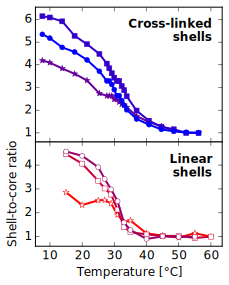

In [66]:
exportFlag = True

colorList = ['#ff0000','#cc0035','#990066','#660099','#3300cc','#0000ff']
labelList = ['L1','L2','L3','X1','X2','X3']

# data sets
sampleLabels = []
xs, ys, labels, colors, markers, lines = [], [], [], [], [], []
bary0s, bardys = [], []
for sampleNum in range(6):
    spectrumCore = spectraCores[0]
    if sampleNum > 2: spectrumCore = spectraCores[1]
    rCorenm = coreRnms[0]
    if sampleNum > 2: rCorenm = coreRnms[1]
    tempList = spectraTemps[sampleNum]
    RhnmList = spectraRhnms[sampleNum]
    label = (labelList[sampleNum])
    color = (colorList[sampleNum])
    marker = (['*','s','o','*','s','o'][sampleNum])
    line = '-'
    x, y = tempList, RhnmList
    y = (y**3 - rCorenm**3)/(y[-1]**3 - rCorenm**3)
    
    xs.append(x), ys.append(y), labels.append(label), 
    colors.append(color), markers.append(marker), lines.append(line)
    sampleLabels.append(label)
    
    
## Construct figure
width = 60.2
height, height2 = 33.8, 46.5
total_height = height + height2
dy, dy2 = max(ys[4])+ 0.8, max(ys[2])+ 0.8
total_dy = dy + dy2
height, height2 = (dy/total_dy)*total_height, (dy2/total_dy)*total_height
fig, (ax, ax2) = plt.subplots(2, sharex=True, 
                              gridspec_kw={'height_ratios':[dy/dy2, 1]})

## Plot lines 
nSets = len(xs)
for setNum in range(nSets):
    fc, ms = 'white', 5
    if setNum > 2: fc = colors[setNum]
    if setNum in [0,3]: ms = 6.5
    if (setNum < 3):
        ax2.plot(xs[setNum], ys[setNum]
                       , label=labels[setNum], color=colors[setNum]
                       , linestyle=lines[setNum], marker=markers[setNum]
                       , markeredgewidth=0.5, markeredgecolor=colors[setNum]
                       , markerfacecolor=fc, markersize=ms
                       , linewidth=2)
    else:
        ax.plot(xs[setNum], ys[setNum]
                       , label=labels[setNum], color=colors[setNum]
                       , linestyle=lines[setNum], marker=markers[setNum]
                       , markeredgewidth=0.5, markeredgecolor=colors[setNum]
                       , markerfacecolor=fc, markersize=ms
                       , linewidth=2)

## Text and sizing
plt.ylabel("Shell-to-core ratio")
plt.xlabel("Temperature [°C]")

xlim = ax.set_xlim([5.5, 63.5])
xticks = np.arange(10, 61, 10)
xticklabels = xticks.astype(int).astype(str)
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)
xlim = ax.set_xlim()

ylim = ax.set_ylim([0.6, dy-0.4])
yticks = np.arange(1, 7)
yticklabels = (yticks.astype(int)).astype(str)
ax.set_yticks(yticks)
ax.set_yticklabels(yticklabels)
ylim = ax.set_ylim() 

ax.text(0.95*xlim[-1], ylim[-1]-0.5, 'Cross-linked\nshells', ha='right', va='top', weight='bold')

# aspect_ratio = width/height
# aspect = ( (xlim[1]-xlim[0])/(ylim[1]-ylim[0]) )/aspect_ratio
# ax.set_aspect(aspect)
    
ylim2 = ax2.set_ylim([0.6, dy2-0.4])
yticks = np.arange(1, 5)
yticklabels = (yticks.astype(int)).astype(str)
ax2.set_yticks(yticks)
ax2.set_yticklabels(yticklabels)
ylim2 = ax2.set_ylim() 

ax2.text(0.95*xlim[-1], ylim2[-1]-0.5, 'Linear\nshells', ha='right', va='top', weight='bold')

# aspect_ratio = width/height2
# aspect = ( (xlim[1]-xlim[0])/(ylim2[1]-ylim2[0]) )/aspect_ratio
# ax2.set_aspect(aspect)


plt.subplots_adjust(wspace=0, hspace=0)

## Save and display
if (exportFlag):
    wmmList = [72, 85]
    matplotlib.rcParams['svg.fonttype'] = 'none'
    timestamp = ('{:%Y%m%d}'.format(datetime.datetime.now()))
    exportFormat = '.svg'
    identifier = '_Swelling-Vol-ratio-vs-Temp'
    folder = 'graphics/'
    for wmm in wmmList:
        fig.set_size_inches(wmm/25.4, 1.28*wmm/25.4)
        fontSize = min([int(ceil(wmm/5.7)), 12])
        matplotlib.rcParams.update({'font.size': fontSize})
        for text in fig.texts:
            text.set_fontsize(fontSize)
        sizeName = '_' + str(wmm) + 'mm'
        filename = folder + timestamp + identifier + sizeName + exportFormat
        plt.savefig(filename, transparent=True); print("Exported to:\n", filename)

plt.show()
        
if (exportFlag): 
    matplotlib.rcParams['svg.fonttype'] = 'path'
    matplotlib.rcParams['font.size'] = 12



## Spectra: Absorbance vs wavelength, with cores

Exported to:
 graphics/20170320_spectrum_L1-thn_85mm.svg
Exported to:
 graphics/20170320_spectrum_L1-thn_63.5mm.svg


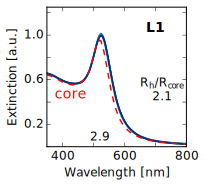

Exported to:
 graphics/20170320_spectrum_L2-med_85mm.svg
Exported to:
 graphics/20170320_spectrum_L2-med_63.5mm.svg


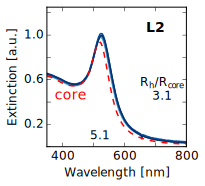

Exported to:
 graphics/20170320_spectrum_L3-thk_85mm.svg
Exported to:
 graphics/20170320_spectrum_L3-thk_63.5mm.svg


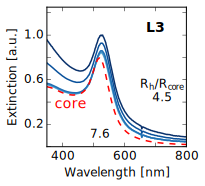

Exported to:
 graphics/20170320_spectrum_X1-thn_85mm.svg
Exported to:
 graphics/20170320_spectrum_X1-thn_63.5mm.svg


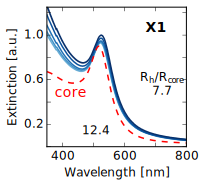

Exported to:
 graphics/20170320_spectrum_X2-med_85mm.svg
Exported to:
 graphics/20170320_spectrum_X2-med_63.5mm.svg


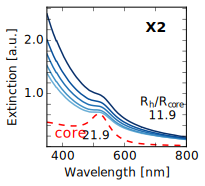

Exported to:
 graphics/20170320_spectrum_X3-thk_85mm.svg
Exported to:
 graphics/20170320_spectrum_X3-thk_63.5mm.svg


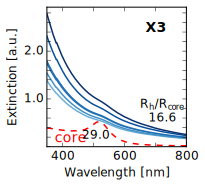

In [195]:
exportFlag = True
pylab.cla()

wlMinnm, wlMaxnm = 350, 800
spectraN = 5
colorList = cm.Blues(np.linspace(0.5, 1, spectraN))
sampleNames = ['L1-thn','L2-med','L3-thk','X1-thn','X2-med','X3-thk']
labelList = ['L1','L2','L3','X1','X2','X3']

for (sampleNum) in range(6):
    spectrumName = sampleNames[sampleNum]
    label = labelList[sampleNum]
    expArray = dataArray[( (dataArray[:,-1] == sampleNum) 
                          & (dataArray[:,0] >= wlMinnm) 
                          & (dataArray[:,0] <= wlMaxnm) )]
    
    xs, ys, colors, lines = [], [], [], []
    
    spectrumCore = spectraCores[0]
    if sampleNum > 2: spectrumCore = spectraCores[1]
    coreRnm = coreRnms[0]
    if (sampleNum > 2): coreRnm = coreRnms[1]
    tempList = spectraTemps[sampleNum]
    RhnmList0 = spectraRhnms[sampleNum]
    RhnmList1 = np.unique(expArray[:, 3])
    
    RhnmIdealList = np.linspace(np.mean(np.sort(RhnmList0)[-2:]), np.mean(np.sort(RhnmList0)[:2]), spectraN)
    RhnmList = []
    for Rhnm in RhnmIdealList:
        RhnmList.append(RhnmList1[np.argsort(np.abs(RhnmList1-Rhnm))][0])
    
    # Swelling series
    yNorm = 1
    for spectrumNum in range(spectraN):
        Rhnm = RhnmList[spectrumNum]
        expSubArray = expArray[(expArray[:, -2] == Rhnm)]
        expSubArray = expSubArray[(np.argsort(expSubArray[:, 0]))]
        color = colorList[spectrumNum]
        line = '-'
        x, y = expSubArray[:,0], expSubArray[:,1]
        if (Rhnm == min(RhnmList)): yNorm = max(y[(x > 510)])
        xs.append(x), ys.append(y), colors.append(color), lines.append(line)
    
    # Core reference
    color = 'red'
    line = '--'
    selection = (spectrumCore[:,0] >= wlMin) & (spectrumCore[:,0] <= wlMax)
    plotArray = spectrumCore[selection]
    x, y = plotArray[:,0], plotArray[:,1]
    if (sampleNum < 4): 
        y0 = y[(x == 505)][0]
        yRef0 = ys[0][(xs[0] == 505)][0]
        y = y*yRef0/y0
    else:
        refScale = 0.95*min(ys[0]/y)
        y = y*refScale
    xs.append(x), ys.append(y), colors.append(color), lines.append(line)
    
    ## Plot lines & set limits
    nSets = len(xs)
    for setNum in range(nSets):
        pylab.plot(xs[setNum], ys[setNum]/yNorm, 
                   color=colors[setNum], linestyle=lines[setNum], linewidth=1.5)
    x, y = [], []
    for setNum in range(nSets):
        for i in range(len(xs[setNum])): 
            x.append(xs[setNum][i]); y.append(ys[setNum][i]/yNorm)
    x, y = np.asarray(x), np.asarray(y)
    xLimits = [np.amin(x), np.amax(x)]
    yLimits = [np.amin(y), np.amax(y)]
    dx, dy = abs(xLimits[1]-xLimits[0]), abs(yLimits[1]-yLimits[0])
    
    ## Text and sizing
    ax = pylab.gca()
    ax.set_ylabel("Extinction [a.u.]")
    ax.set_xlabel("Wavelength [nm]")

    xlim = ax.set_xlim([wlMinnm, wlMaxnm])
    xticks = np.arange(400, 850, 100)
    xticklabels = xticks.astype(int).astype(str)
    xticklabels[[1,3]] = '', ''
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    xlim = ax.set_xlim()

    ylim = ax.set_ylim([0,1.25])
    if (sampleNum > 3): ylim = ax.set_ylim([0, 1.05*max(y)])
    yticks = np.arange(ylim[0], ylim[-1], 0.2)
    yticklabels = yticks.astype(str)
    ytickslabeled = [0.2, 0.6, 1.0]
    if (sampleNum > 3): ytickslabeled = [1.0, 2.0]
    for i in range(len(yticks)): 
        if (np.round(yticks[i],1) in np.round(ytickslabeled,1)): yticklabels[i] = '{0:.1f}'.format(yticks[i])
        else: yticklabels[i] = ''
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticklabels)
    ylim = ax.set_ylim() 
    
    xpos = 375
    ypos = 0.95*min(ys[-1][(xs[-1] < 500)]/yNorm)
    ax.text(xpos, ypos, 'core', color='red', size=14, ha='left', va='top')

    xpos = 700
    ypos = ylim[0] + 0.85*(ylim[1]-ylim[0])
    ax.text(xpos, ypos, label, weight='bold', size=14, ha='center', va='center')
    
    x1, x2 = 575.0, 625.0
    y1 = np.mean(y[(x == x1)])
    y2 = np.mean(y[(x == x2)])
    dx = 25
    x1, x2 = x1-dx, x2+dx
    
#     xpos, ypos = 0.5*(x1+x2), 0.5*(y1+y2)
#     dydx = (y2-y1)/(x1-x2)
#     xa1, xa2 = xpos + dx, xpos - dx
#     ya1, ya2 = ypos + dx*dydx, ypos - dx*dydx
#     pylab.plot([xa1, xa2], [ya1, ya2], linewidth=3, color='black')
    
    xpos = x2
    ypos = y1
    RhRatio = min(RhnmList0)/coreRnm
    text = '$R_h$/$R_{\mathrm{core}}$'+'\n{0:.1f}'.format(RhRatio)
    ax.text(xpos, ypos, text, ha='left', va='bottom', multialignment='center')
    
    xpos = x1
    ypos = y2
    RhRatio = max(RhnmList0)/coreRnm
    text = '{0:.1f}'.format(RhRatio)
    ax.text(xpos, ypos, text, ha='right', va='top', multialignment='center')

    aspect_ratio = 1
    aspect = ( (xlim[1]-xlim[0])/(ylim[1]-ylim[0]) )/aspect_ratio
    ax.set_aspect(aspect)

    ## Save and display
    if (exportFlag):
        fig = pylab.gcf()
        wmmList = [85, 63.5]
        matplotlib.rcParams['svg.fonttype'] = 'none'
        timestamp = ('{:%Y%m%d}'.format(datetime.datetime.now()))
        exportFormat = '.svg'
        identifier = '_spectrum_' + spectrumName
        folder = 'graphics/'
        for wmm in wmmList:
            fig.set_size_inches(wmm/25.4, 1.1*wmm/25.4)
            fontSize = min([int(ceil(wmm/5.7)), 12])
            matplotlib.rcParams.update({'font.size': fontSize})
            for text in fig.texts:
                text.set_fontsize(fontSize)
            sizeName = '_' + str(wmm) + 'mm'
            filename = folder + timestamp + identifier + sizeName + exportFormat
            plt.savefig(filename, transparent=True); print("Exported to:\n", filename)

    plt.show()

    if (exportFlag): 
        matplotlib.rcParams['svg.fonttype'] = 'path'
        matplotlib.rcParams['font.size'] = 12

